In [ ]:
import pandas as pd
import numpy as 
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import resample
from datasets import Dataset
from setfit import SetFitModel, SetFitTrainer
from sentence_transformers.losses import CosineSimilarityLoss
from sklearn.metrics import precision_recall_fscore_support

#LLM
from openai import OpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field, ValidationError
from typing import List, Optional, Dict
from datetime import date
import time
from tqdm import tqdm
np.random.seed(42)


# Load in data

In [ ]:
owner = pd.read_csv('tm_owner2.csv')
application = pd.read_csv('tm_application.csv')



In [ ]:
term = pd.read_csv("tm_term_clean.csv")

In [ ]:
term.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9992369 entries, 0 to 9992368
Data columns (total 4 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Unnamed: 0         int64 
 1   ApplicationNumber  int64 
 2   Nice               int64 
 3   full_description   object
dtypes: int64(3), object(1)
memory usage: 304.9+ MB


In [ ]:
term.head(10)

,Unnamed: 0,ApplicationNumber,Nice,full_description
0,1,15939341,9,NaN
1,2,15939341,9,integrated software packages
2,3,15939366,9,NaN
3,4,15939366,9,integrated software packages
4,5,16047557,11,gas cleaners and purifiers; gas scrubbing appa...
5,6,16047557,11,household air cleaners; air purifiers ; air pu...
6,7,16047557,11,axial fans
7,8,16047557,11,air purifying apparatus and machines
8,9,16047557,11,pans
9,10,16047557,11,fans for gas extractors


In [ ]:
owner.head()

,Unnamed: 0,ApplicantIdentifier,owner_name_original,LATWGS84,LONGWGS84,Country_EUIPO
0,64,14537,Fußballclub Gelsenkirchen-Schalke 04 e.V.,51.51152,7.09308,GERMANY
1,385,25526,COMPRESSANA GMBH,48.99321,12.19590,GERMANY
2,389,47203,Kneipp GmbH,49.79299,9.93651,GERMANY
3,416,75639,MorphoSys AG,48.10360,11.42013,GERMANY
4,418,16992,Sanacorp Pharmahandel GmbH,48.10360,11.42013,GERMANY


In [ ]:
application.head()

,Unnamed: 0,ApplicationNumber,ApplicantIdentifier,Year,ApplicationDate,EUIPO_green_dummy
0,1,15891757,786922.0,2017,2017-01-19,0
1,2,15939341,746464.0,2017,2017-01-11,0
2,3,15939366,746464.0,2017,2017-01-11,0
3,4,16047557,775154.0,2017,2017-02-13,1
4,5,16047557,1161622.0,2017,2017-02-13,1


In [ ]:
#merge 2 datasets
df = term.merge(application[['ApplicationNumber', 'EUIPO_green_dummy', 'ApplicantIdentifier','Year']],on='ApplicationNumber', how='left')

In [ ]:
application['Year'].value_counts()

Year
2020    135715
2019    112492
2018    111589
2017    107288
2021     31087
Name: count, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10251766 entries, 0 to 10251765
Data columns (total 7 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Unnamed: 0           int64  
 1   ApplicationNumber    int64  
 2   Nice                 int64  
 3   full_description     object 
 4   EUIPO_green_dummy    int64  
 5   ApplicantIdentifier  float64
 6   Year                 int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 547.5+ MB


In [ ]:
df = df[df['full_description'].notna()]


In [ ]:
df.head(10)

,Unnamed: 0,ApplicationNumber,Nice,full_description,EUIPO_green_dummy,ApplicantIdentifier
1,2,15939341,9,integrated software packages,0,746464.0
3,4,15939366,9,integrated software packages,0,746464.0
4,5,16047557,11,gas cleaners and purifiers; gas scrubbing appa...,1,775154.0
5,5,16047557,11,gas cleaners and purifiers; gas scrubbing appa...,1,1161622.0
6,6,16047557,11,household air cleaners; air purifiers ; air pu...,1,775154.0
7,6,16047557,11,household air cleaners; air purifiers ; air pu...,1,1161622.0
8,7,16047557,11,axial fans,1,775154.0
9,7,16047557,11,axial fans,1,1161622.0
10,8,16047557,11,air purifying apparatus and machines,1,775154.0
11,8,16047557,11,air purifying apparatus and machines,1,1161622.0


In [ ]:
#merge all datasets into one

df = df.merge(owner[['ApplicantIdentifier', 'owner_name_original', 'Country_EUIPO', 'LATWGS84','LONGWGS84']],
              on='ApplicantIdentifier', how='left')

In [ ]:
df = df[df['Country_EUIPO'].notna()]


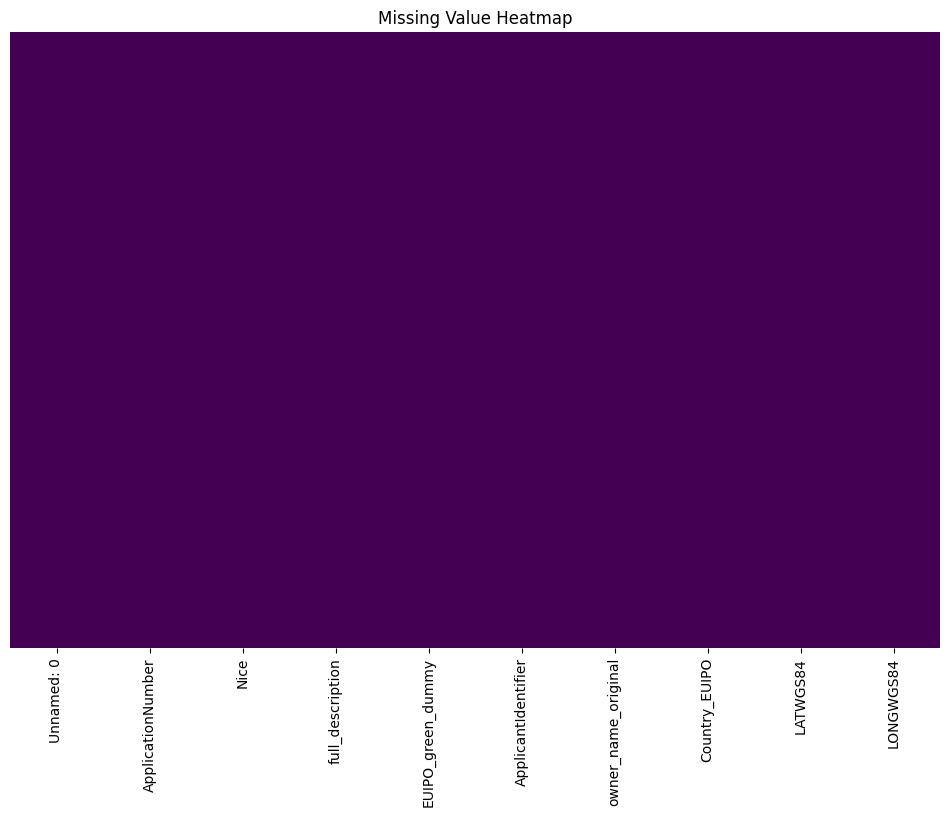


Missing values per column:
Unnamed: 0              0
ApplicationNumber       0
Nice                    0
full_description        0
EUIPO_green_dummy       0
ApplicantIdentifier     0
owner_name_original    70
Country_EUIPO           0
LATWGS84               38
LONGWGS84              38
dtype: int64


In [ ]:
#Show the missing values
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Value Heatmap")
plt.show()

#Also show the amount of missing value
# Check the missing values
print("\nMissing values per column:")
print(df.isnull().sum())

In [ ]:
#remove all na
df = df.dropna()

# Descriptive

In [ ]:
filtered_df = df[df['ApplicationNumber'] == 18189937]
green_dummy_count = filtered_df['EUIPO_green_dummy'].sum()
print(f"Number of entries with EUIPO_green_dummy as 1 for ApplicationNumber 18189937: {green_dummy_count}")

Number of entries with EUIPO_green_dummy as 1 for ApplicationNumber 18189937: 651


In [ ]:
country_counts_rows = df.groupby('Country_EUIPO')['ApplicationNumber'].count()
country_counts_rows

Country_EUIPO
GERMANY    1637287
SPAIN       669842
Name: ApplicationNumber, dtype: int64

In [ ]:
application_counts = df['ApplicationNumber'].value_counts()
unique_application_numbers = application_counts[application_counts == 1]
print(f"Number of application numbers that appear only once: {len(unique_application_numbers)}")

Number of application numbers that appear only once: 7305


In [ ]:
application_counts = df['ApplicationNumber'].value_counts()
multiple_application_numbers = application_counts[application_counts > 1]
print(f"Number of unique application numbers that appear more than once: {len(multiple_application_numbers)}")

Number of unique application numbers that appear more than once: 83657


In [ ]:
unique_countries_per_application = df.groupby('ApplicationNumber')['Country_EUIPO'].unique()

applications_with_both_countries = []
for app_num, countries in unique_countries_per_application.items():
    if 'SPAIN' in countries and 'GERMANY' in countries:
        applications_with_both_countries.append(app_num)

if applications_with_both_countries:
    print(f"There are {len(applications_with_both_countries)} application(s) that have both Spanish and German entries.")
    print("Application Numbers: ", applications_with_both_countries)
else:
    print("No application found that has both Spanish and German entries.")

There are 1 application(s) that have both Spanish and German entries.
Application Numbers:  [16665887]


In [ ]:
owner['Country_EUIPO'].value_counts()

,count
Country_EUIPO,
GERMANY,36187
SPAIN,21107


In [ ]:
df[df['ApplicationNumber']== 18189937]

,Unnamed: 0,ApplicationNumber,Nice,full_description,EUIPO_green_dummy,ApplicantIdentifier,owner_name_original,Country_EUIPO,LATWGS84,LONGWGS84
6799422,6854722,18189937,7,mine borers,1,1042945.0,Euroline GmbH,GERMANY,53.60022,9.83751
6799423,6854723,18189937,7,ore treating machines,1,1042945.0,Euroline GmbH,GERMANY,53.60022,9.83751
6799424,6854724,18189937,7,crank shafts,1,1042945.0,Euroline GmbH,GERMANY,53.60022,9.83751
6799425,6854725,18189937,7,anti-pollution devices for motors and engines;...,1,1042945.0,Euroline GmbH,GERMANY,53.60022,9.83751
6799426,6854726,18189937,7,fuel injectors for internal combustion engines...,1,1042945.0,Euroline GmbH,GERMANY,53.60022,9.83751
...,...,...,...,...,...,...,...,...,...,...
6800068,6855369,18189937,12,"wheels and tyres, and continuous tracks for ve...",1,1042945.0,Euroline GmbH,GERMANY,53.60022,9.83751
6800069,6855370,18189937,12,upholstery for vehicle seats,1,1042945.0,Euroline GmbH,GERMANY,53.60022,9.83751
6800070,6855371,18189937,12,mine cars,1,1042945.0,Euroline GmbH,GERMANY,53.60022,9.83751
6800071,6855372,18189937,12,military vehicles,1,1042945.0,Euroline GmbH,GERMANY,53.60022,9.83751


# Aggregate descriptions

In [ ]:
df_aggyear = df.groupby('ApplicationNumber').agg({
    'full_description': lambda x: ' '.join(x),
    'EUIPO_green_dummy': 'max',  # green if any description is green
    'ApplicantIdentifier': 'first',
    'owner_name_original': 'first',
    'Country_EUIPO': 'first',
    'Nice': 'first',
    'Year': 'first',
    'LATWGS84': 'first',
    'LONGWGS84': 'first'}).reset_index()


In [ ]:
df_agg = df.groupby('ApplicationNumber').agg({
    'full_description': lambda x: ' '.join(x),
    'EUIPO_green_dummy': 'max',  # green if any description is green
    'ApplicantIdentifier': 'first',
    'owner_name_original': 'first',
    'Country_EUIPO': 'first',
    'LATWGS84': 'first',
    'LONGWGS84': 'first'}).reset_index()

In [ ]:
df_aggyear['Country_EUIPO'].value_counts()

Country_EUIPO
GERMANY    60688
SPAIN      30274
Name: count, dtype: int64

In [ ]:
df_aggnice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90962 entries, 0 to 90961
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ApplicationNumber    90962 non-null  int64  
 1   full_description     90962 non-null  object 
 2   EUIPO_green_dummy    90962 non-null  int64  
 3   ApplicantIdentifier  90962 non-null  float64
 4   owner_name_original  90962 non-null  object 
 5   Country_EUIPO        90962 non-null  object 
 6   Nice                 90962 non-null  int64  
 7   LATWGS84             90962 non-null  float64
 8   LONGWGS84            90962 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 6.2+ MB


In [ ]:
df_aggyear['word_count'] = df_aggyear['full_description'].apply(lambda x: len(x.split()))
print(df_agg['word_count'].mean())

201.99738352278973


In [ ]:
print(df_agg['word_count'].max(), df_agg['word_count'].min())

4498 1


In [ ]:
# Filter rows with less than 200 words
df_agg3 = df_agg[df_agg['word_count'] < 200].reset_index(drop=True)

In [ ]:
df_agg[df_agg['ApplicationNumber']==18189937]


,ApplicationNumber,full_description,EUIPO_green_dummy,ApplicantIdentifier,owner_name_original,Country_EUIPO,LATWGS84,LONGWGS84,word_count
66411,18189937,mine borers ore treating machines crank shaft...,1,1042945.0,Euroline GmbH,GERMANY,53.60022,9.83751,3748


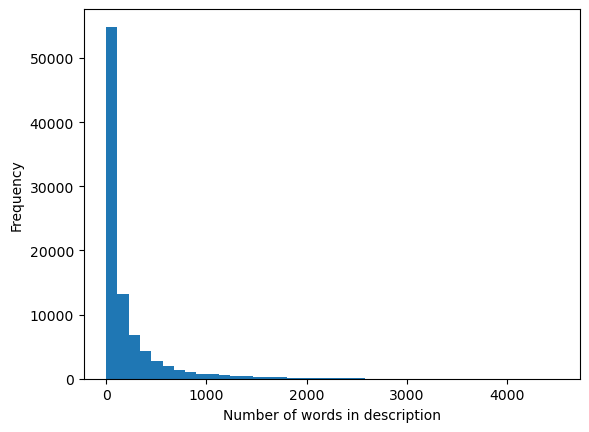

In [ ]:
plt.hist(df_agg['word_count'], bins=40)
plt.xlabel("Number of words in description")
plt.ylabel("Frequency")
plt.show()

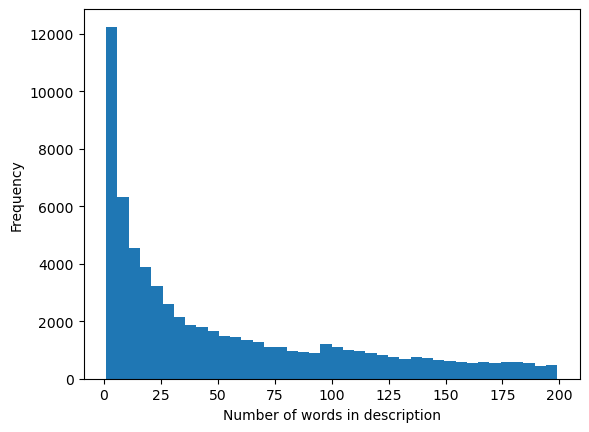

In [ ]:
plt.hist(df_agg3['word_count'], bins= 40)
plt.xlabel("Number of words in description")
plt.ylabel("Frequency")
plt.show()

C:\Users\timo\AppData\Local\Temp\ipykernel_33008\2166809835.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aggnicegreen[NICE_COL] = pd.to_numeric(df_aggnicegreen[NICE_COL], errors='coerce')


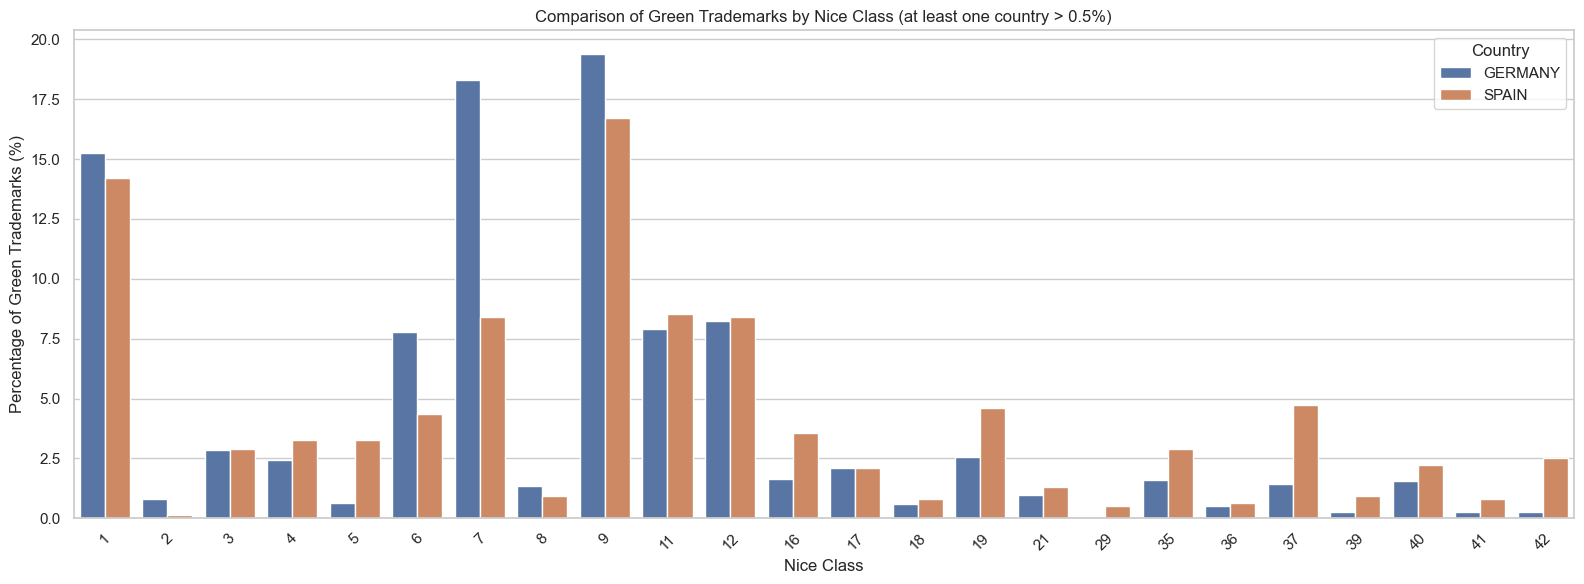

Country_EUIPO    GERMANY      SPAIN
Nice                               
1              15.275229  14.210526
2               0.825688   0.131579
3               2.844037   2.894737
4               2.431193   3.289474
5               0.642202   3.289474
6               7.798165   4.342105
7              18.302752   8.421053
8               1.330275   0.921053
9              19.403670  16.710526
11              7.889908   8.552632
12              8.256881   8.421053
16              1.651376   3.552632
17              2.110092   2.105263
18              0.596330   0.789474
19              2.568807   4.605263
21              0.963303   1.315789
29              0.000000   0.526316
35              1.605505   2.894737
36              0.504587   0.657895
37              1.422018   4.736842
39              0.275229   0.921053
40              1.559633   2.236842
41              0.275229   0.789474
42              0.275229   2.500000


In [ ]:


COUNTRY_COL = "Country_EUIPO"
NICE_COL = "Nice"
GREEN_COL = "EUIPO_green_dummy"
COUNTRIES = ["GERMANY", "SPAIN"]
THRESHOLD = 0.5  # show Nice class if at least one country has > 0.5%

# Filter only green trademarks and selected countries
df_aggnicegreen = df_aggyear[(df_aggyear[GREEN_COL] == 1) & (df_aggyear[COUNTRY_COL].isin(COUNTRIES))]

# Ensure Nice is numeric
df_aggnicegreen[NICE_COL] = pd.to_numeric(df_aggnicegreen[NICE_COL], errors='coerce')
df_aggnicegreen = df_aggnicegreen.dropna(subset=[NICE_COL])

# -GROUP & COMPUTE PERCENTAGE
counts = df_aggnicegreen.groupby([COUNTRY_COL, NICE_COL]).size().reset_index(name="green_count")
total_green = df_aggnicegreen.groupby(COUNTRY_COL).size().reset_index(name="total_green")
counts = counts.merge(total_green, on=COUNTRY_COL)
counts["percent_of_green"] = counts["green_count"] / counts["total_green"] * 100

# FILL MISSING NICE CLASSES WITH 0% 
all_nice = np.arange(1, 46)  # Nice classes 1-45
all_combinations = pd.MultiIndex.from_product([COUNTRIES, all_nice], names=[COUNTRY_COL, NICE_COL])
counts = counts.set_index([COUNTRY_COL, NICE_COL]).reindex(all_combinations, fill_value=0).reset_index()

#  FILTER Nice classes where both countries < THRESHOLD 
table_check = counts.pivot(index=NICE_COL, columns=COUNTRY_COL, values="percent_of_green").fillna(0)
nice_to_keep = table_check[(table_check > THRESHOLD).any(axis=1)].index
counts_filtered = counts[counts[NICE_COL].isin(nice_to_keep)]

#  PLOT GROUPED BAR CHART 
plt.figure(figsize=(16,6))
sns.barplot(x=NICE_COL, y="percent_of_green", hue=COUNTRY_COL, data=counts_filtered)
plt.xticks(rotation=45)
plt.xlabel("Nice Class")
plt.ylabel("Percentage of Green Trademarks (%)")
plt.title(f"Comparison of Green Trademarks by Nice Class (at least one country > {THRESHOLD}%)")
plt.legend(title="Country")
plt.tight_layout()
plt.show()

# TABLE 
table = counts_filtered.pivot(index=NICE_COL, columns=COUNTRY_COL, values="percent_of_green").fillna(0)
table = table.sort_index()
print(table)



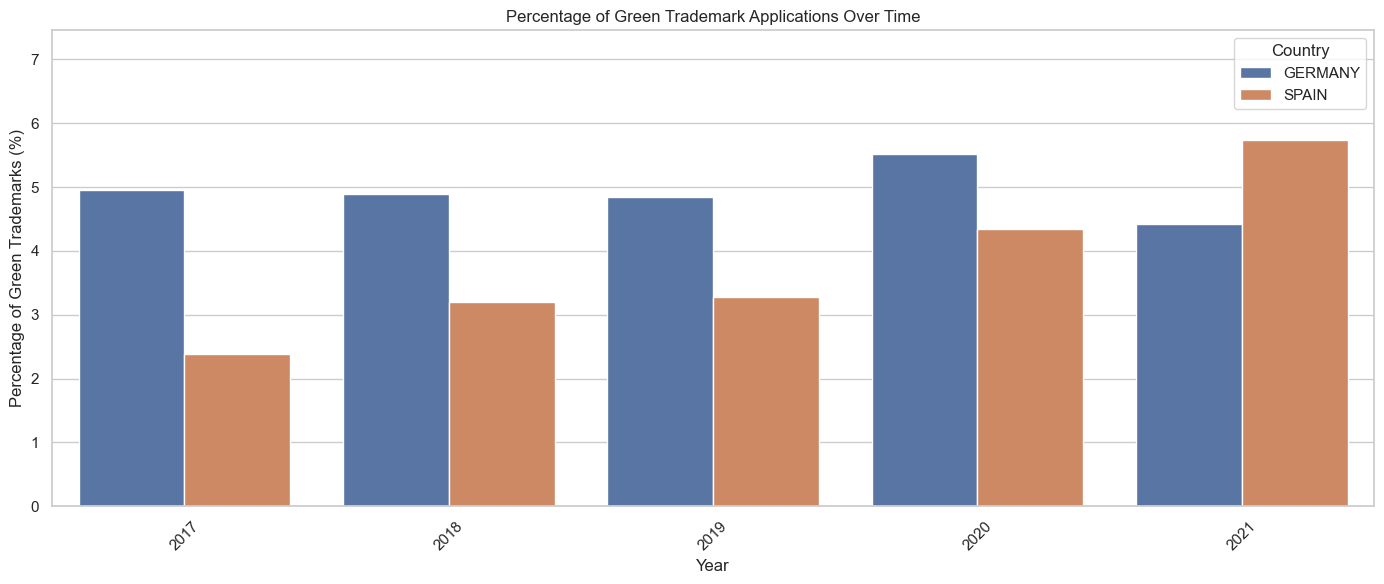

Country_EUIPO  GERMANY  SPAIN
Year                         
2017              4.95   2.38
2018              4.90   3.20
2019              4.84   3.28
2020              5.52   4.35
2021              4.42   5.73


In [ ]:


YEAR_COL = "Year"
COUNTRY_COL = "Country_EUIPO"
GREEN_COL = "EUIPO_green_dummy"
COUNTRIES = ["GERMANY", "SPAIN"]

# FILTER COUNTRIES 
df_year = df_aggyear[df_aggyear[COUNTRY_COL].isin(COUNTRIES)].copy()

# TOTAL TRADEMARKS PER YEAR & COUNTRY 
total_counts = (
    df_year
    .groupby([COUNTRY_COL, YEAR_COL])
    .size()
    .reset_index(name="total_trademarks")
)

# GREEN TRADEMARKS PER YEAR & COUNTRY 
green_counts = (
    df_year[df_year[GREEN_COL] == 1]
    .groupby([COUNTRY_COL, YEAR_COL])
    .size()
    .reset_index(name="green_trademarks")
)

# MERGE & CALCULATE PERCENTAGE 
yearly = total_counts.merge(
    green_counts,
    on=[COUNTRY_COL, YEAR_COL],
    how="left"
)

yearly["green_trademarks"] = yearly["green_trademarks"].fillna(0)
yearly["percent_green"] = (
    yearly["green_trademarks"] / yearly["total_trademarks"] * 100
)

yearly = yearly.sort_values(by=YEAR_COL)


plt.figure(figsize=(14,6))
sns.barplot(
    data=yearly,
    x=YEAR_COL,
    y="percent_green",
    hue=COUNTRY_COL
)

plt.xlabel("Year")
plt.ylabel("Percentage of Green Trademarks (%)")
plt.title("Percentage of Green Trademark Applications Over Time")
plt.legend(title="Country")
plt.xticks(rotation=45)

y_max = yearly["percent_green"].max()
plt.ylim(0, y_max * 1.3)

plt.tight_layout()
plt.show()


table = yearly.pivot(
    index=YEAR_COL,
    columns=COUNTRY_COL,
    values="percent_green"
).round(2)

print(table)


In [ ]:
COUNTRY_COL = "Country_EUIPO"
GREEN_COL = "EUIPO_green_dummy"
COUNTRIES = ["GERMANY", "SPAIN"]

# Filter relevant countries
df_countries = df_aggyear[df_aggyear[COUNTRY_COL].isin(COUNTRIES)].copy()

# Total trademarks per country
total_counts = df_countries.groupby(COUNTRY_COL).size().reset_index(name="total_trademarks")

# Green trademarks per country
green_counts = df_countries[df_countries[GREEN_COL] == 1].groupby(COUNTRY_COL).size().reset_index(name="green_trademarks")

# Merge and calculate percentage
summary = total_counts.merge(green_counts, on=COUNTRY_COL, how="left")
summary["green_trademarks"] = summary["green_trademarks"].fillna(0)
summary["percent_green"] = (summary["green_trademarks"] / summary["total_trademarks"] * 100).round(2)

print(summary)


  Country_EUIPO  total_trademarks  green_trademarks  percent_green
0       GERMANY             43196              2180           5.05
1         SPAIN             22691               760           3.35


In [ ]:
df_agg3['Country_EUIPO'].value_counts()

Country_EUIPO
GERMANY    43196
SPAIN      22691
Name: count, dtype: int64

In [ ]:
df_agg3.head()

,ApplicationNumber,full_description,EUIPO_green_dummy,ApplicantIdentifier,owner_name_original,Country_EUIPO,LATWGS84,LONGWGS84,word_count
0,16214331,hygienic preparations and articles dental prep...,0,803704.0,Centax Pharma GmbH,GERMANY,48.13641,11.57754,23
1,16214363,prepared dishes consisting principally of meat...,0,151586.0,"MARIA DIET, S.L.",SPAIN,39.85183,-0.48851,56
2,16214389,drinks made from dairy products; dairy-based b...,0,151586.0,"MARIA DIET, S.L.",SPAIN,39.85183,-0.48851,107
3,16214405,milling tools tools mills machining,0,788162.0,Metaux Precieux Dental Holding GmbH,GERMANY,47.82672,10.02050,5
4,16214462,milling tools tools mills machining,0,788162.0,Metaux Precieux Dental Holding GmbH,GERMANY,47.82672,10.02050,5


# Divide dataset between Germany and Spain

In [ ]:
df_germany = df_agg3[df_agg3['Country_EUIPO'] == 'GERMANY']
df_spain = df_agg3[df_agg3['Country_EUIPO'] == 'SPAIN']

print("Germany DataFrame Head:")
display(df_germany.head())
print(f"Shape of Germany DataFrame: {df_germany.shape}")


print("\nSpain DataFrame Head:")
display(df_spain.head())
print(f"Shape of Spain DataFrame: {df_spain.shape}")

Germany DataFrame Head:


,ApplicationNumber,full_description,EUIPO_green_dummy,ApplicantIdentifier,owner_name_original,Country_EUIPO,LATWGS84,LONGWGS84,word_count
0,16214331,hygienic preparations and articles dental preparations and articles dietary supplements and dietetic preparations; dietary supplements and dietetic preparations containing cbd oil medical preparations,0,803704.0,Centax Pharma GmbH,GERMANY,48.13641,11.57754,23
3,16214405,milling tools tools mills machining,0,788162.0,Metaux Precieux Dental Holding GmbH,GERMANY,47.82672,10.02050,5
4,16214462,milling tools tools mills machining,0,788162.0,Metaux Precieux Dental Holding GmbH,GERMANY,47.82672,10.02050,5
5,16214471,milling tools tools mills machining,0,788162.0,Metaux Precieux Dental Holding GmbH,GERMANY,47.82672,10.02050,5
6,16214488,milling tools tools mills machining,0,788162.0,Metaux Precieux Dental Holding GmbH,GERMANY,47.82672,10.02050,5


Shape of Germany DataFrame: (43196, 9)

Spain DataFrame Head:


,ApplicationNumber,full_description,EUIPO_green_dummy,ApplicantIdentifier,owner_name_original,Country_EUIPO,LATWGS84,LONGWGS84,word_count
1,16214363,"prepared dishes consisting principally of meat desserts made from milk products mincemeat milk prepared meat dishes jams vegetable spreads prepared dishes consisting primarily of fishcakes, vegetables, boiled eggs, and broth cocoa fruit jellies ; jellies truffles cocoa coffee chocolates coffee honey substitutes foods with a cocoa base chocolate preparations for making of sugar confectionery truffle honey",0,151586.0,"MARIA DIET, S.L.",SPAIN,39.85183,-0.48851,56
2,16214389,"drinks made from dairy products; dairy-based beverages; milk beverages; beverages made from milk; milk drinks processed fish desserts made from milk products milk fish, smoked fish milk products; dairy products; food preparations predominantly of milk meat gelatines gelatine molluscs, jams dairy products and dairy substitutes dried edible seaweed sausages vegetable spreads fish jellies dried edible algae cured sausages fish extracts dried seafood cocoa sauces coffee substitutes coffee concentrates malt coffee flavourings, aromatic preparations for food sauce vegetal preparations for use as coffee substitutes; coffee substitutes cocoa coffee spice extracts chocolates coffee spice preparations honey substitutes foods with a cocoa base chocolate condiments spices seasonings fish sauce ice",0,151586.0,"MARIA DIET, S.L.",SPAIN,39.85183,-0.48851,107
9,16214637,watches,0,803776.0,JOU GASOL,SPAIN,41.72540,1.82373,1
11,16214678,"compressors generators machining dispensing machines knives kitchen knives edged and blunt weapons lifting tools hand-operated tools and implements for treatment of materials, and for construction, repair and maintenance hand-operated hygienic and beauty implements for humans and animals boilers burners heating, ventilating, and air conditioning and purification equipment refrigerating and freezing equipment personal heating and drying implements filters for industrial and household use lighting and lighting reflectors sun tanning appliances vehicles and conveyances parts and fittings for vehicles land vehicles and conveyances playground apparatus sporting articles and equipment fairground and playground apparatus toys festive decorations, party novelties and artificial christmas trees",0,621792.0,KEYTON TECH CORPORATION S.L.,SPAIN,38.34410,-0.48043,100
12,16214793,sanitary preparations for medical purposes; sanitary preparations for medical use veterinary preparations dietetic substances adapted for medical use; dietetic products for medical purposes dietetic preparations adapted for medical use; dietetic preparations adapted for medical purposes disinfectants nutritional supplements; dietary supplements for medical use; food supplements for medical purposes medicinal oils; oils materials for dressings dietetic food preparations adapted for medical use; dietetic food preparations adapted for medical purposes; dietetic foodstuffs for medical purposes; dietetic foods for medicinal purposes dietetic foods adapted for medical purposes; dietetic foods adapted for medical use; dietetic food adapted for medical use nutritional supplements made of starch adapted for medical use medicine pharmaceuticals diabetic fruit nectars adapted for medical purposes; diabetic fruit nectars adapted for medical use diabetic fruit juice beverages adapted for medical purposes; diabetic fruit juice beverages adapted for medical use,0,71246.0,"FORMDIET, S.A.",SPAIN,41.56337,0.52824,137


Shape of Spain DataFrame: (22691, 9)


# Analysis using SBERT

In [ ]:
green_refs2 = [
    "air purification",
    "eco friendly",
    "green design",
    "recycled packaging",
    "alternative energy",
    "eco innovation",
    "green innovation",
    "recycled products",
    "anaerobic digestion",
    "eco solutions",
    "green manufacturing",
    "regenerative braking",
    "bio-based materials",
    "ecodesign",
    "green technology",
    "renewable energy",
    "biodegradable polymers",
    "ecological design",
    "green transportation",
    "resource efficient",
    "biodegradable products",
    "ecological footprint",
    "greenhouse gas",
    "resource recovery",
    "biodiversity",
    "electric motors",
    "greenhouse gases",
    "solar geoengineering",
    "electric vehicles",
    "hybrid vehicles",
    "solar panels",
    "biomass",
    "energy conservation",
    "hydroelectric dams",
    "sustainability metrics",
    "bioplastics",
    "energy efficiency",
    "hydroponics",
    "sustainability practices",
    "energy efficient",
    "hydropower",
    "sustainable agriculture",
    "carbon filters",
    "energy optimization",
    "leed certified",
    "sustainable development",
    "carbon neutral",
    "energy recovery",
    "life cycle",
    "sustainable farming",
    "carbon offsetting",
    "energy savings",
    "lightweight materials",
    "sustainable forestry",
    "carbon sequestration",
    "environmental certification",
    "low emission",
    "sustainable manufacturing",
    "cellulosic plastics",
    "environmental compliance",
    "low impact",
    "sustainable materials",
    "circular economy",
    "environmental conservation",
    "material compatibility",
    "sustainable practices",
    "clean energy",
    "environmental labeling",
    "organic farming",
    "vertical farming",
    "clean production",
    "environmental management",
    "photocatalysis",
    "waste minimization",
    "clean technology",
    "environmental policy",
    "plant based",
    "waste recycling",
    "climate adaptation",
    "environmental stewardship",
    "pollution control",
    "waste reduction",
    "climate friendly",
    "fuel cells",
    "precision agriculture",
    "water conservation",
    "compostable materials",
    "geothermal",
    "product lifespan",
    "water efficient",
    "composting",
    "geothermal power",
    "public transportation",
    "wind turbines",
    "dioxide capture",
    "global warming",
    "rainwater harvesting",
    "zero emissions",
    "eco conscious",
    "green buildings",
    "recyclable materials",
    "zero waste",
    "eco efficient",
    "green chemistry",
    "recycled materials"
]
# Load SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode reference descriptions
green_ref_embeddings2 = model.encode(green_refs2, convert_to_numpy=True)

In [ ]:
germany_sample= df_germany.sample(n=5000, random_state=42) 
germany_sample.head()

,ApplicationNumber,full_description,EUIPO_green_dummy,ApplicantIdentifier,owner_name_original,Country_EUIPO,LATWGS84,LONGWGS84,word_count
3958,16564338,bioinformatics software technological services,0,815889.0,Xenadi,GERMANY,53.55562,9.98745,4
35713,18099325,steering wheels steering wheels wheels wheel...,0,1021529.0,Codausi,GERMANY,53.45337,7.83894,7
6543,16885212,digestants disinfectants materials for dressin...,0,769720.0,Aristo Pharma GmbH,GERMANY,52.51604,13.37691,7
37181,18122839,"frozen vegetables butter milk game, fish, po...",0,418378.0,DOVGAN GmbH,GERMANY,53.55562,9.98745,51
22417,17942326,electronic control units detectors monitors r...,0,57606.0,Continental Teves AG & Co. OHG,GERMANY,50.11208,8.68341,24


In [ ]:
descriptions = germany_sample['full_description'].fillna("").tolist()
desc_embeddings = model.encode(descriptions, convert_to_numpy=True)
#3000 in 3 min

In [ ]:
similarity_scores = cosine_similarity(desc_embeddings, green_ref_embeddings2)

# Take maximum similarity to any green reference as green score
max_similarity = similarity_scores.max(axis=1)
germany_sample['green_similarity_score'] = max_similarity
best_ref_index = similarity_scores.argmax(axis=1)
germany_sample['best_matching_green_ref'] = [green_refs2[i] for i in best_ref_index]


In [ ]:
germany_sample_sorted = germany_sample.sort_values(by='green_similarity_score', ascending=False)
display(germany_sample_sorted.head(10))

,ApplicationNumber,full_description,EUIPO_green_dummy,ApplicantIdentifier,owner_name_original,Country_EUIPO,LATWGS84,LONGWGS84,word_count,green_similarity_score,best_matching_green_ref
12532,17548025,electric driving motors for machines; electric...,1,620018.0,BINOVA GmbH,GERMANY,51.05363,13.74081,18,0.775619,electric motors
23608,17958981,electric driving motors for machines; electric...,0,137301.0,ZIEHL-ABEGG SE,GERMANY,49.27934,9.68784,27,0.683218,electric motors
21529,17932202,"chemicals, carbonates activators carbon carb...",0,741867.0,Vulkatec Riebensahm GmbH,GERMANY,50.44122,7.40030,51,0.673901,carbon filters
32783,18062766,"motors, water pumps machining",0,462151.0,Zehnder Pumpen GmbH,GERMANY,50.57971,12.81019,4,0.667341,electric motors
18537,17893263,electrical energy from renewable sources elect...,1,922236.0,Solinac GmbH,GERMANY,48.11905,11.42847,13,0.662058,renewable energy
29808,18028917,trees trees and forestry products,0,719475.0,WeGrow GmbH,GERMANY,51.32060,6.49536,5,0.660511,sustainable forestry
44304,18211374,electric motors for wheelchairs wheels wheels,0,872721.0,Alber GmbH,GERMANY,48.21425,9.02479,6,0.652340,electric motors
19940,17913953,"turbines, power transmissions and gearing for...",1,875405.0,Flender GmbH,GERMANY,51.83478,6.61663,25,0.634973,wind turbines
51613,18309281,electrical energy from solar power,1,1123713.0,Solarize Energy Solutions GmbH,GERMANY,48.76778,9.17203,5,0.634882,solar panels
35981,18102271,"sterilizers heating, ventilating, and air con...",0,1023534.0,Schmitz,GERMANY,47.74194,8.97098,9,0.634825,air purification


In [ ]:
max_words = germany_sample_sorted['word_count'].max()
germany_sample_sorted['weighted_similarity'] = germany_sample_sorted['green_similarity_score'] * (germany_sample_sorted['word_count'] / max_words)
germany_sample_sorted1 = germany_sample_sorted.sort_values(by='weighted_similarity', ascending=False)
display(germany_sample_sorted1.head(10))

,ApplicationNumber,full_description,EUIPO_green_dummy,ApplicantIdentifier,owner_name_original,Country_EUIPO,LATWGS84,LONGWGS84,word_count,green_similarity_score,best_matching_green_ref,weighted_similarity
2144,16409831,refrigerated vehicles; vehicles scooters moto...,1,814189.0,Pohl,GERMANY,51.35033,9.52595,197,0.526438,electric vehicles,0.521147
10674,17320466,electric driving motors for machines; electric...,1,764883.0,AMK Holding GmbH & Co. KG,GERMANY,48.64607,9.45233,179,0.540202,electric vehicles,0.485910
27500,18005591,electrical energy from renewable sources elect...,1,974493.0,Power Play Ventures UG,GERMANY,49.23175,6.99850,170,0.524634,renewable energy,0.448179
5633,16762692,photovoltaic solar modules voltage converters ...,1,626347.0,asola Technologies GmbH,GERMANY,50.97793,11.02351,184,0.479706,solar panels,0.443547
27823,18010102,metal karabiners building and construction mat...,1,977443.0,Ganzoo OHG,GERMANY,48.37034,10.89788,193,0.418671,lightweight materials,0.406048
22213,17939980,sunglass nose pads paper stationery decoration...,0,857710.0,Reisenthel Accessoires GmbH & Co. KG,GERMANY,48.10910,11.30010,198,0.396000,recycled materials,0.394010
31613,18049764,machines for washing clothing ; machines for w...,0,997282.0,Rupprecht,GERMANY,50.77823,6.08864,184,0.423884,electric motors,0.391933
11781,17478207,power generators for vehicles electric generat...,1,868993.0,Kutlu,GERMANY,51.39734,7.18072,147,0.518876,electric motors,0.383290
2027,16399693,chemical compositions for water treatment; che...,1,813553.0,iGas energy GmbH,GERMANY,50.77149,6.22759,186,0.408070,waste reduction,0.381412
1945,16393779,chemical compositions for water treatment; che...,1,813553.0,iGas energy GmbH,GERMANY,50.77149,6.22759,186,0.408070,waste reduction,0.381412


In [ ]:
germany_sample_sorted['green_similarity_score'].mean()

np.float32(0.27561513)

In [ ]:
#which one has euipo green dummy a 1 in percentage
germany_sample['EUIPO_green_dummy'].value_counts()

,count
EUIPO_green_dummy,
0,4711
1,289


In [ ]:
cutoff_score = germany_sample_sorted.iloc[288]["green_similarity_score"]   
# Assign final green label
germany_sample_sorted["predicted_green"] = (germany_sample_sorted["green_similarity_score"] >= cutoff_score).astype(int)

print("Similarity cutoff =", cutoff_score)
print(germany_sample_sorted["predicted_green"].value_counts())
germany_sample_sorted['green_similarity_score'].mean()

Similarity cutoff = 0.427798
predicted_green
0    4711
1     289
Name: count, dtype: int64


np.float32(0.27561513)

# results using sbert only  (NOT USED)

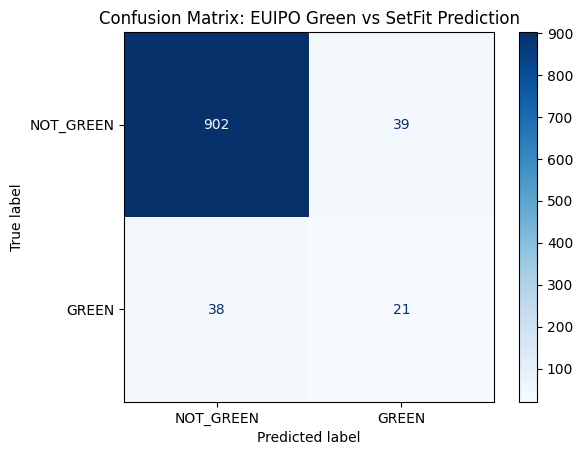

Classification Report:

              precision    recall  f1-score   support

   NOT_GREEN       0.96      0.96      0.96       941
       GREEN       0.35      0.36      0.35        59

    accuracy                           0.92      1000
   macro avg       0.65      0.66      0.66      1000
weighted avg       0.92      0.92      0.92      1000



In [ ]:

# Compute confusion matrix
cm = confusion_matrix(germany_sample_sorted['EUIPO_green_dummy'], germany_sample_sorted['predicted_green'])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NOT_GREEN", "GREEN"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: EUIPO Green vs SetFit Prediction")
plt.show()
report = classification_report(germany_sample_sorted['EUIPO_green_dummy'], germany_sample_sorted['predicted_green'], target_names=["NOT_GREEN", "GREEN"])
print("Classification Report:\n")
print(report)


In [ ]:
germany_sample_sorted['predicted_green'].value_counts()

,count
predicted_green,
0,940
1,60


In [ ]:
average_green_similarity = germany_sample_sorted.groupby('EUIPO_green_dummy')['green_similarity_score'].mean()
display(average_green_similarity)

,green_similarity_score
EUIPO_green_dummy,
0,0.267856
1,0.384621




---





---



# Set fit Models start

# Loading in manually labeled 20 green and 20 non green from germany & validation manually labeled

In [ ]:
germanual = pd.read_excel("germany_sample_sorted.xlsx")

In [ ]:
germanual = germanual.dropna()
germanual.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 112 to 4979
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ApplicationNumber       40 non-null     int64  
 1   full_description        40 non-null     object 
 2   EUIPO_green_dummy       40 non-null     int64  
 3   word_count              40 non-null     int64  
 4   green_similarity_score  40 non-null     float64
 5   weighted_similarity     40 non-null     float64
 6   Manual labeling         40 non-null     float64
dtypes: float64(3), int64(3), object(1)
memory usage: 2.5+ KB


In [ ]:
germanual["label"] = germanual["Manual_Label"]


In [ ]:
#drop trained from dataset so they cant be sampled into validatoin
df_validation_pool = germany_sample_sorted.drop(germanual.index, errors='ignore')

In [ ]:
validation_sample = df_validation_pool.sample(n=250, random_state=42)

In [ ]:
validation_sample.to_excel("Validation_Random_250_Sample.xlsx", index=True)

In [ ]:
#load back in after manual labeling
validation_set = pd.read_excel("Validation_Random_250_Sample.xlsx")

In [ ]:
validation_set["label"] = validation_set['Label']


# First model using paraphrase

In [ ]:


# 1. LOAD DATA



train_ds = Dataset.from_pandas(germanual[['full_description', 'label']].rename(columns={'full_description': 'text'}))
val_ds = Dataset.from_pandas(validation_set[['full_description', 'label']].rename(columns={'full_description': 'text'}))

# 2. INITIALIZE MODEL

model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

# 3. CONFIGURE TRAINER
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=20, 
    num_epochs=1,      #
    column_mapping={"text": "text", "label": "label"} 
)

# 4. TRAIN
trainer.train()

# 5. COMPREHENSIVE EVALUATION

metrics = trainer.evaluate()
print(f"Basic Metrics: {metrics}")

# Custom evaluation for Precision/Recall
preds = model.predict(val_ds["text"])
precision, recall, f1, _ = precision_recall_fscore_support(val_ds["label"], preds, average='binary')

print(f"--- 📊 Final Performance Report (at 6% Prevalence) ---")
print(f"Accuracy:  {accuracy_score(val_ds['label'], preds):.2%}")
print(f"Precision: {precision:.2%}  <-- How many 'Green' flags were actually right?")
print(f"Recall:    {recall:.2%}     <-- How many of the real 'Green' rows did we find?")
print(f"F1 Score:  {f1:.2%}      <-- Overall balance of the two")

# 6. SAVE THE MODEL
model.save_pretrained("green_trademark_model_v1")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
C:\Users\timo\AppData\Local\Temp\ipykernel_33008\1900775845.py:19: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1600
  Batch size = 16
  Num epochs = 1
c:\Users\timo\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.451100
50,0.095700
100,0.000900


***** Running evaluation *****


Basic Metrics: {'accuracy': 0.836}
--- 📊 Final Performance Report (at 6% Prevalence) ---
Accuracy:  83.60%
Precision: 19.57%  <-- How many 'Green' flags were actually right?
Recall:    69.23%     <-- How many of the real 'Green' rows did we find?
F1 Score:  30.51%      <-- Overall balance of the two


In [ ]:

# Get model probabilities → convert from torch tensor → numpy
probas = model.predict_proba(val_ds["text"])[:, 1]
probas = probas.detach().cpu().numpy()   
thresholds = np.arange(0.05, 0.95, 0.05)

best_precision = 0
best_threshold = 0

y_true = np.array(val_ds["label"])

print("Threshold tuning...\n")
print("thr   precision   recall   f1    TP  FP  FN  TN")
print("-"*60)

for thr in thresholds:
    y_pred = (probas >= thr).astype(int)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    print(f"{thr:0.2f}   {precision:0.3f}     {recall:0.3f}   {f1:0.3f}   {tp:2d}  {fp:2d}  {fn:2d}  {tn:3d}")

    if precision > best_precision and tp > 0:
        best_precision = precision
        best_threshold = thr

print("\n🔥 BEST THRESHOLD FOR PRECISION:", best_threshold)
print(f"Precision at this threshold: {best_precision:.3f}")

final_preds = (probas >= best_threshold).astype(int)

print("\nFinal confusion matrix at best precision threshold:")
print(confusion_matrix(y_true, final_preds))


Threshold tuning...

thr   precision   recall   f1    TP  FP  FN  TN
------------------------------------------------------------
0.05   0.128     0.769   0.220   10  68   3  169
0.10   0.154     0.769   0.256   10  55   3  182
0.15   0.159     0.769   0.263   10  53   3  184
0.20   0.169     0.769   0.278   10  49   3  188
0.25   0.185     0.769   0.299   10  44   3  193
0.30   0.189     0.769   0.303   10  43   3  194
0.35   0.200     0.769   0.317   10  40   3  197
0.40   0.204     0.769   0.323   10  39   3  198
0.45   0.191     0.692   0.300    9  38   4  199
0.50   0.196     0.692   0.305    9  37   4  200
0.55   0.205     0.692   0.316    9  35   4  202
0.60   0.214     0.692   0.327    9  33   4  204
0.65   0.214     0.692   0.327    9  33   4  204
0.70   0.225     0.692   0.340    9  31   4  206
0.75   0.231     0.692   0.346    9  30   4  207
0.80   0.257     0.692   0.375    9  26   4  211
0.85   0.273     0.692   0.391    9  24   4  213
0.90   0.276     0.615   0.381    8  

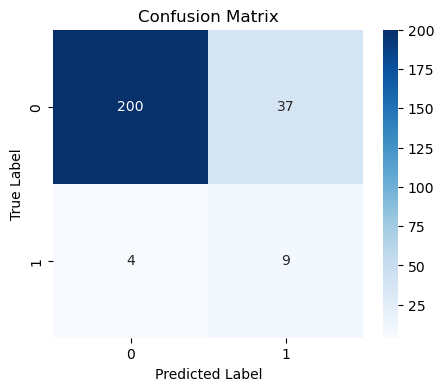

Confusion Matrix:
[[200  37]
 [  4   9]]


In [ ]:
cm = confusion_matrix(val_ds["label"], preds)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("Confusion Matrix:")
print(cm)

# Model 2 with all mpnet model also epochs =3

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
C:\Users\timo\AppData\Local\Temp\ipykernel_33008\36818415.py:31: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1600
  Batch size = 16
  Num epochs = 3


Step,Training Loss
1,0.411900
50,0.120500
100,0.000500
150,0.000200
200,0.000200
250,0.000200
300,0.000200


Threshold tuning...

thr   precision   recall   f1    TP  FP  FN  TN
------------------------------------------------------------
0.05   0.052     1.000   0.099   13  237   0    0
0.10   0.052     1.000   0.099   13  237   0    0
0.15   0.175     0.846   0.289   11  52   2  185
0.20   0.184     0.692   0.290    9  40   4  197
0.25   0.196     0.692   0.305    9  37   4  200
0.30   0.214     0.692   0.327    9  33   4  204
0.35   0.237     0.692   0.353    9  29   4  208
0.40   0.243     0.692   0.360    9  28   4  209
0.45   0.257     0.692   0.375    9  26   4  211
0.50   0.242     0.615   0.348    8  25   5  212
0.55   0.250     0.615   0.356    8  24   5  213
0.60   0.258     0.615   0.364    8  23   5  214
0.65   0.267     0.615   0.372    8  22   5  215
0.70   0.276     0.615   0.381    8  21   5  216
0.75   0.286     0.615   0.390    8  20   5  217
0.80   0.296     0.615   0.400    8  19   5  218
0.85   0.333     0.538   0.412    7  14   6  223
0.90   0.000     0.000   0.000    0

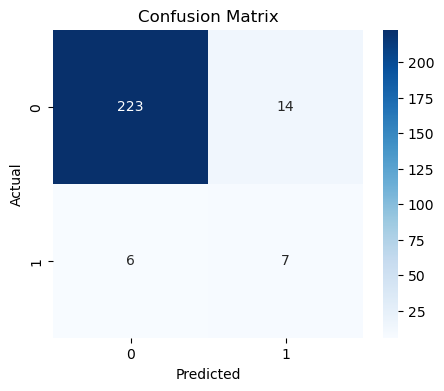

Model saved as green_trademark_model_v2


In [ ]:



# Load SetFit model

model2 = SetFitModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")


#  Create trainer

trainer = SetFitTrainer(
    model=model2,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    metric="accuracy",
    batch_size=16,
    num_epochs=3,       # Increase epochs for better few-shot performance
)


# Train the classifier

trainer.train()


# Evaluate on validation set

probas = model2.predict_proba(val_ds["text"])[:, 1].detach().cpu().numpy()
y_true = np.array(val_ds["label"])

# 
#  Trehreshold tuning for precision/recall
# 
thresholds = np.arange(0.05, 0.95, 0.05)
best_f1 = 0
best_threshold = 0

print("Threshold tuning...\n")
print("thr   precision   recall   f1    TP  FP  FN  TN")
print("-"*60)

for thr in thresholds:
    y_pred = (probas >= thr).astype(int)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"{thr:0.2f}   {precision:0.3f}     {recall:0.3f}   {f1:0.3f}   {tp:2d}  {fp:2d}  {fn:2d}  {tn:3d}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thr

print("\n🔥 BEST THRESHOLD (F1):", best_threshold)

# Final predictions
final_preds = (probas >= best_threshold).astype(int)


# Final evaluation

precision = precision_score(y_true, final_preds)
recall = recall_score(y_true, final_preds)
f1 = f1_score(y_true, final_preds)
cm = confusion_matrix(y_true, final_preds)

print("\nFinal Metrics at Best Threshold:")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")

print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# -----------------------------
# 10. Save the model
# -----------------------------
model.save_pretrained("green_trademark_model_v2")
print("Model saved as green_trademark_model_v2")


In [ ]:
model2.save_pretrained("green_trademark_model_v2goed")


# putting model 1 wrong predicted on validation set, move to training set

In [ ]:


CUSTOM_THRESHOLD = 0.7 




# Reload the trained model
try:
    model = SetFitModel.from_pretrained("green_trademark_model_v1") 
except:
    print("Warning: Saved model not found. Loading base MPNet model.")
    model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")


# Convert Dataset objects back to Pandas for manipulation
train_df = train_ds.to_pandas().rename(columns={'text': 'full_description'})
val_df = val_ds.to_pandas().rename(columns={'text': 'full_description'})


# . IDENTIFY MISCLASSIFIED ROWS USING CUSTOM THRESHOLD

#  Get the raw probability scores for class 1 (Green)

probabilities = model.predict_proba(val_df['full_description'].tolist())

val_df['green_proba'] = probabilities[:, 1] 

# Apply the custom threshold to generate the predicted label

val_df['predicted_label'] = np.where(
    val_df['green_proba'] >= CUSTOM_THRESHOLD, 
    1, 
    0
)

# Find the rows where the model made a mistake (FN or FP)
val_df['is_correct'] = (val_df['label'] == val_df['predicted_label'])
misclassified_df = val_df[val_df['is_correct'] == False].drop(columns=['predicted_label', 'is_correct', 'green_proba'])

print(f"Found {len(misclassified_df)} misclassified rows at threshold {CUSTOM_THRESHOLD}.")
print(f"Initial Training Size: {len(train_df)}")
print(f"Initial Validation Size: {len(val_df)}")


#  CREATE THE AUGMENTED TRAINING SET 
rows_to_add = misclassified_df[['full_description', 'label']]
augmented_train_df = pd.concat([train_df, rows_to_add], ignore_index=True)
augmented_train_df.drop_duplicates(subset=['full_description'], inplace=True) 
augmented_train_df.reset_index(drop=True, inplace=True) 

print(f"Augmented Training Set Size: {len(augmented_train_df)} rows")


# CREATE THE REDUCED (UNBIASED) VALIDATION SET 
new_val_df = val_df[val_df['is_correct'] == True].drop(columns=['predicted_label', 'is_correct', 'green_proba'])
new_val_df.reset_index(drop=True, inplace=True) # CRITICAL FIX

print(f"Reduced Validation Set Size: {len(new_val_df)} rows")


# CONVERT BACK TO DATASET OBJECTS FOR SETFIT
final_train_ds = Dataset.from_pandas(
    augmented_train_df.rename(columns={'full_description': 'text'})
)

final_val_ds = Dataset.from_pandas(
    new_val_df.rename(columns={'full_description': 'text'})
)

print("\n✅ Data preparation complete. Proceed to Re-Training (Part 2).")



Found 35 misclassified rows at threshold 0.7.
Initial Training Size: 40
Initial Validation Size: 250
Augmented Training Set Size: 74 rows
Reduced Validation Set Size: 215 rows

✅ Data preparation complete. Proceed to Re-Training (Part 2).


c:\Users\timo\anaconda3\Lib\site-packages\pandas\core\construction.py:632: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  data = np.array(data, copy=copy)


# re-train but using fresh model paraphrase (Final model used)

In [ ]:

# INITIALIZE MODEL
# Start fresh with the MPNet model to get the most benefit from the new data
new_model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

# CONFIGURE TRAINER (with new data and tuning)
trainer = SetFitTrainer(
    model=new_model,
    train_dataset=final_train_ds,  # The augmented set (approx. 66 rows)
    eval_dataset=final_val_ds,     # The reduced, unbiased set (approx. 224 rows)
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=30,  
    num_epochs=1,       
    column_mapping={"text": "text", "label": "label"} 
)



In [ ]:

preds_scores = new_model.predict_proba(list(final_val_ds["text"]))


CUSTOM_THRESHOLD = 0.7 
preds_labels = np.where(preds_scores[:, 1] >= CUSTOM_THRESHOLD, 1, 0)
# Calculate the final metrics on the unbiased data
precision, recall, f1, _ = precision_recall_fscore_support(
    final_val_ds["label"], 
    preds_labels, 
    average='binary', 
    zero_division=0
)

print(f"\n--- 📊 Final Performance Report (on UNBIASED data at Threshold {CUSTOM_THRESHOLD}) ---")
print(f"Total Validation Rows: {len(final_val_ds)}")
print(f"Accuracy:  {accuracy_score(final_val_ds['label'], preds_labels):.2%}")
print(f"Precision: {precision:.2%}  <-- How many flags were correct?")
print(f"Recall:    {recall:.2%}     <-- How many actual 'Green' rows were found?")
print(f"F1 Score:  {f1:.2%}      <-- Overall balance")

# 9. SAVE THE IMPROVED MODEL
# Save the model as v2 to distinguish it from the initial version
new_model.save_pretrained("model1_augmented(best)")



--- 📊 Final Performance Report (on UNBIASED data at Threshold 0.7) ---
Total Validation Rows: 215
Accuracy:  99.53%
Precision: 100.00%  <-- How many flags were correct?
Recall:    88.89%     <-- How many actual 'Green' rows were found?
F1 Score:  94.12%      <-- Overall balance

✅ Improved Model saved to: 'green_trademark_classifier_v2_augmented'


In [ ]:

cm = confusion_matrix(final_val_ds["label"], preds_labels)

#Display the Matrix and Key Metrics

print("\n--- 🧠 Confusion Matrix (at Threshold 0.7) ---")
print("Predicted:   | 0 (Not Green) | 1 (Green)")
print("---------------------------------------")
print(f"Actual 0 (Not Green) | {cm[0, 0]} (TN)  | {cm[0, 1]} (FP)")
print(f"Actual 1 (Green)     | {cm[1, 0]} (FN)    | {cm[1, 1]} (TP)")
print("---------------------------------------")

# Calculate the actual counts
TN = cm[0, 0] # True Negatives
FP = cm[0, 1] # False Positives
FN = cm[1, 0] # False Negatives
TP = cm[1, 1] # True Positives

print(f"\nTotal Actual Green (TP + FN): {TP + FN}")
print(f"Total Predicted Green (TP + FP): {TP + FP}")


final_precision = TP / (TP + FP) if (TP + FP) > 0 else 0
final_recall = TP / (TP + FN) if (TP + FN) > 0 else 0

print(f"\nFinal Precision (TP / (TP + FP)): {final_precision:.2%}")
print(f"Final Recall (TP / (TP + FN)): {final_recall:.2%}")



--- 🧠 Confusion Matrix (at Threshold 0.7) ---
Predicted:   | 0 (Not Green) | 1 (Green)
---------------------------------------
Actual 0 (Not Green) | 206 (TN)  | 0 (FP)
Actual 1 (Green)     | 1 (FN)    | 8 (TP)
---------------------------------------

Total Actual Green (TP + FN): 9
Total Predicted Green (TP + FP): 8

Final Precision (TP / (TP + FP)): 100.00%
Final Recall (TP / (TP + FN)): 88.89%


# New model first training multilingual

In [ ]:


# 1. LOAD DATA



train_dsmulti = Dataset.from_pandas(germanual[['full_description', 'label']].rename(columns={'full_description': 'text'}))
val_dsmulti = Dataset.from_pandas(validation_set[['full_description', 'label']].rename(columns={'full_description': 'text'}))

# 2. INITIALIZE MODEL
# We use a multilingual model since these are German trademarks
modelmulti = SetFitModel.from_pretrained("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

# 3. CONFIGURE TRAINER
trainermulti = SetFitTrainer(
    model=modelmulti,
    train_dataset=train_dsmulti,
    eval_dataset=val_dsmulti,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=20, # Number of pairs to generate for contrastive learning
    num_epochs=1,      # Number of epochs for fine-tuning
    column_mapping={"text": "text", "label": "label"} 
)

# 4. TRAIN
trainermulti.train()



In [ ]:


# 1. Get probabilities
probas = modelmulti.predict_proba(list(val_dsmulti["text"]))

# Convert to numpy if needed
if hasattr(probas, "detach"):
    probas = probas.detach().cpu().numpy()

# ✅ KEEP ONLY probability of class 1 (green)
probas = probas[:, 1]

# 2. True labels
y_true = np.array(val_dsmulti["label"]).astype(int)

# 3. Thresholds
thresholds = np.arange(0.05, 0.95, 0.05)

best_precision = 0
best_threshold = 0

print("Threshold tuning...\n")
print("thr   precision   recall   f1    TP  FP  FN  TN")
print("-"*60)

for thr in thresholds:
    y_pred = (probas >= thr).astype(int)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall    = recall_score(y_true, y_pred, zero_division=0)
    f1        = f1_score(y_true, y_pred, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    print(f"{thr:0.2f}   {precision:0.3f}     {recall:0.3f}   {f1:0.3f}   "
          f"{tp:2d}  {fp:2d}  {fn:2d}  {tn:3d}")

    if precision > best_precision and tp > 0:
        best_precision = precision
        best_threshold = thr

print("\n🔥 BEST THRESHOLD FOR PRECISION:", best_threshold)
print(f"Precision at this threshold: {best_precision:.3f}")

# 4. Final predictions
final_preds = (probas >= best_threshold).astype(int)

print("\nFinal confusion matrix at best precision threshold:")
print(confusion_matrix(y_true, final_preds))



Threshold tuning...

thr   precision   recall   f1    TP  FP  FN  TN
------------------------------------------------------------
0.05   0.162     0.846   0.272   11  57   2  180
0.10   0.169     0.769   0.278   10  49   3  188
0.15   0.170     0.692   0.273    9  44   4  193
0.20   0.180     0.692   0.286    9  41   4  196
0.25   0.205     0.692   0.316    9  35   4  202
0.30   0.209     0.692   0.321    9  34   4  203
0.35   0.195     0.615   0.296    8  33   5  204
0.40   0.184     0.538   0.275    7  31   6  206
0.45   0.194     0.538   0.286    7  29   6  208
0.50   0.206     0.538   0.298    7  27   6  210
0.55   0.212     0.538   0.304    7  26   6  211
0.60   0.226     0.538   0.318    7  24   6  213
0.65   0.250     0.538   0.341    7  21   6  216
0.70   0.259     0.538   0.350    7  20   6  217
0.75   0.269     0.538   0.359    7  19   6  218
0.80   0.304     0.538   0.389    7  16   6  221
0.85   0.333     0.538   0.412    7  14   6  223
0.90   0.389     0.538   0.452    7  

In [ ]:
modelmulti.save_pretrained("Model_multilingual-paraphrase")


# run the new model on updated train set while using new model

In [ ]:


#  CONFIGURATION: YOUR CHOSEN THRESHOLD 
CUSTOM_THRESHOLD = 0.7 



# Reload the trained model
try:
    model2de = SetFitModel.from_pretrained("Model_multilingual-paraphrase") 
except:
    print("Warning: Saved model not found. Loading base MPNet model.")
    modeld1e = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")


# Convert Dataset objects back to Pandas for manipulation
train_dfmulti = train_dsmulti.to_pandas().rename(columns={'text': 'full_description'})
val_dfmulti = val_dsmulti.to_pandas().rename(columns={'text': 'full_description'})


# -IDENTIFY MISCLASSIFIED ROWS USING CUSTOM THRESHOLD

# A) Get the raw probability scores for class 1 (Green)
# model.predict_proba returns probabilities for all classes (Class 0 and Class 1)
probabilities = model2de.predict_proba(val_dfmulti['full_description'].tolist())
# For binary classification, we care about the probability of the positive class (index 1)
val_dfmulti['green_proba'] = probabilities[:, 1] 

#  Apply the custom threshold to generate the predicted label
# Predicted Label is 1 (Green) IF the probability is >= CUSTOM_THRESHOLD (0.7)
val_dfmulti['predicted_label'] = np.where(
    val_dfmulti['green_proba'] >= CUSTOM_THRESHOLD, 
    1, 
    0
)

# Find the rows where the model made a mistake (FN or FP)
val_dfmulti['is_correct'] = (val_dfmulti['label'] == val_dfmulti['predicted_label'])
misclassified_df2 = val_dfmulti[val_dfmulti['is_correct'] == False].drop(columns=['predicted_label', 'is_correct', 'green_proba'])

print(f"Found {len(misclassified_df2)} misclassified rows at threshold {CUSTOM_THRESHOLD}.")
print(f"Initial Training Size: {len(train_dfmulti)}")
print(f"Initial Validation Size: {len(val_dfmulti)}")


#  CREATE THE AUGMENTED TRAINING SET 
rows_to_add = misclassified_df2[['full_description', 'label']]
augmented_train_df2 = pd.concat([train_dfmulti, rows_to_add], ignore_index=True)
augmented_train_df2.drop_duplicates(subset=['full_description'], inplace=True) 
augmented_train_df2.reset_index(drop=True, inplace=True)
print(f"Augmented Training Set Size: {len(augmented_train_df2)} rows")


#  CREATE THE REDUCED (UNBIASED) VALIDATION SET 
new_val_df2 = val_dfmulti[val_dfmulti['is_correct'] == True].drop(columns=['predicted_label', 'is_correct', 'green_proba'])
new_val_df2.reset_index(drop=True, inplace=True) # CRITICAL FIX

print(f"Reduced Validation Set Size: {len(new_val_df2)} rows")


# -CONVERT BACK TO DATASET OBJECTS FOR SETFIT
final_train_dsmulti = Dataset.from_pandas(
    augmented_train_df2.rename(columns={'full_description': 'text'})
)

final_val_dsmulti = Dataset.from_pandas(
    new_val_df2.rename(columns={'full_description': 'text'})
)

print("\n Data preparation complete. Proceed to Re-Training (Part 2).")



Found 26 misclassified rows at threshold 0.7.
Initial Training Size: 40
Initial Validation Size: 250
Augmented Training Set Size: 65 rows
Reduced Validation Set Size: 224 rows

✅ Data preparation complete. Proceed to Re-Training (Part 2).


c:\Users\timo\anaconda3\Lib\site-packages\pandas\core\construction.py:632: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  data = np.array(data, copy=copy)


In [ ]:
paralingval = SetFitModel.from_pretrained("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")
trainer_refined = SetFitTrainer(
    model=paralingval,                  # continue training the existing model
    train_dataset=final_train_dsmulti,
    eval_dataset=final_val_dsmulti,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=20,  # or increase if you want stronger contrastive learning
    num_epochs=1,       # can increase to 3-5 for more refinement
    column_mapping={"text": "text", "label": "label"}
)
trainer_refined.train()


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
C:\Users\timo\AppData\Local\Temp\ipykernel_33008\1539908796.py:2: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer_refined = SetFitTrainer(
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset


Map:   0%|          | 0/65 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 2600
  Batch size = 16
  Num epochs = 1
c:\Users\timo\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.401700
50,0.145500
100,0.001300
150,0.000400


In [ ]:
paralingval.save_pretrained("MultiLingOnNewValidation")

In [ ]:
# Paralingual model after adding validation set to train, then training the original model again


# 1. Get probabilities
probas = MultiLingOnNewValidation.predict_proba(list(final_val_dsmulti["text"]))

# Convert to numpy if needed
if hasattr(probas, "detach"):
    probas = probas.detach().cpu().numpy()

#  KEEP ONLY probability of class 1 (green)
probas = probas[:, 1]

# 2. True labels
y_true = np.array(final_val_dsmulti["label"]).astype(int)

# 3. Thresholds
thresholds = np.arange(0.05, 0.95, 0.05)

best_precision = 0
best_threshold = 0

print("Threshold tuning...\n")
print("thr   precision   recall   f1    TP  FP  FN  TN")
print("-"*60)

for thr in thresholds:
    y_pred = (probas >= thr).astype(int)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall    = recall_score(y_true, y_pred, zero_division=0)
    f1        = f1_score(y_true, y_pred, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    print(f"{thr:0.2f}   {precision:0.3f}     {recall:0.3f}   {f1:0.3f}   "
          f"{tp:2d}  {fp:2d}  {fn:2d}  {tn:3d}")

    if precision > best_precision and tp > 0:
        best_precision = precision
        best_threshold = thr

print("\n🔥 BEST THRESHOLD FOR PRECISION:", best_threshold)
print(f"Precision at this threshold: {best_precision:.3f}")

# 4. Final predictions
final_preds = (probas >= best_threshold).astype(int)

print("\nFinal confusion matrix at best precision threshold:")
print(confusion_matrix(y_true, final_preds))



Threshold tuning...

thr   precision   recall   f1    TP  FP  FN  TN
------------------------------------------------------------
0.05   0.167     0.857   0.279    6  30   1  187
0.10   0.188     0.857   0.308    6  26   1  191
0.15   0.207     0.857   0.333    6  23   1  194
0.20   0.214     0.857   0.343    6  22   1  195
0.25   0.214     0.857   0.343    6  22   1  195
0.30   0.231     0.857   0.364    6  20   1  197
0.35   0.240     0.857   0.375    6  19   1  198
0.40   0.261     0.857   0.400    6  17   1  200
0.45   0.286     0.857   0.429    6  15   1  202
0.50   0.300     0.857   0.444    6  14   1  203
0.55   0.300     0.857   0.444    6  14   1  203
0.60   0.316     0.857   0.462    6  13   1  204
0.65   0.316     0.857   0.462    6  13   1  204
0.70   0.316     0.857   0.462    6  13   1  204
0.75   0.353     0.857   0.500    6  11   1  206
0.80   0.375     0.857   0.522    6  10   1  207
0.85   0.500     0.857   0.632    6   6   1  211
0.90   0.545     0.857   0.667    6  

# Evaluation 

# Select a sample of 1000 to see how many greeen of spanish all words

In [532]:
df_test= df_spain.sample(n=1000, random_state=42)

In [ ]:
test_subset = df_test[['full_description', 'ApplicationNumber']]

# Save to Excel
test_subset.to_excel("test_set_full_descriptions_and_application_numbers.xlsx", index=False)

In [533]:
df_test['EUIPO_green_dummy'].value_counts()

EUIPO_green_dummy
0    957
1     43
Name: count, dtype: int64

# LLM classifier

In [ ]:
# Load environment variables from .env file

load_dotenv()
api_key = os.getenv("GEMINI_API_KEY")

client = None
if not api_key:
    print("⚠️ Set GEMINI_API_KEY in environment or a .env file")
else:
    # Configure the OpenAI client to point to Google's endpoint
    client = OpenAI(
        api_key=api_key,
        base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
    )
    print("✅ OpenAI client configured for Gemini.")``

In [ ]:


class GreenClassification(BaseModel):
    """
    Green = environmentally related 
    """
    green: bool = Field(
        description="True if environmentally related, False otherwise."
    )

green_schema = GreenClassification.model_json_schema()


In [ ]:


def classify_green(text, retries=2):
    for attempt in range(retries):
        try:
            completion = client.chat.completions.create(
                model="gemini-2.5-flash-lite",
                messages=[
                    {
                        "role": "system",
                        "content": (
                            "Classify the trademark description as environmentally related ('green') "
                            "or not. Green means related to sustainability, environmental protection, "
                            "renewable energy, recycling, low environmental impact, or eco-friendly goods "
                            "or services. Base your decision only on the text.\n\n"
                            "Return a JSON object with the key 'green'."
                        )
                    },
                    {"role": "user", "content": text}
                ],
                response_format={
                    "type": "json_schema",
                    "json_schema": {
                        "name": "GreenClassification",
                        "strict": True,
                        "schema": green_schema
                    }
                },
                timeout=60
            )

            response_text = completion.choices[0].message.content
            return GreenClassification.model_validate_json(response_text)

        except ValidationError as ve:
            print(f"Validation error (attempt {attempt+1}): {ve}")
            time.sleep(1)
        except Exception as e:
            print(f"Error (attempt {attempt+1}): {e}")
            time.sleep(1)

    return None


In [ ]:
df = pd.read_excel(
    "test_set_full_descriptions_and_application_numbers.xlsx"
)

results = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    result = classify_green(row["full_description"])

    if result is not None:
        results.append({
            "application_number": row["ApplicationNumber"],
            "green": result.green
        })


classified_dfllm2 = pd.DataFrame(results)


In [528]:
classified_dfllm2["green_LLM2"] = classified_dfllm2["green"].astype(int)


In [529]:
# Example if df_test has "ApplicationNumber" and classified_df has "application_number"
classified_dfllm2 = classified_dfllm2.rename(columns={"application_number": "ApplicationNumber"})


In [534]:
# Merge classified results into df_test
df_test2= df_test.merge(
    classified_dfllm2[["ApplicationNumber", "green_LLM2"]],
    on="ApplicationNumber",
    how="left"  
)


In [462]:
df_test2[df_test2['application_number']== 18156277








]

,application_number,full_description,EUIPO_green_dummy,ApplicantIdentifier,owner_name_original,Country_EUIPO,LATWGS84,LONGWGS84,word_count,green_LLM,green_probam1,green_predm1,green_probam2,green_predm2,green_probam3,green_predm3,green_probam4,green_predm4,green_probam5,green_predm5
271,18156277,organic composts,0,117151.0,"BIOMASS TECHNOLOGY, S.L.",SPAIN,41.95617,2.79895,2,1,0.959343,1,0.367528,0,0.974454,1,0.987856,1,0.978573,1


# Model Evalation of LLM

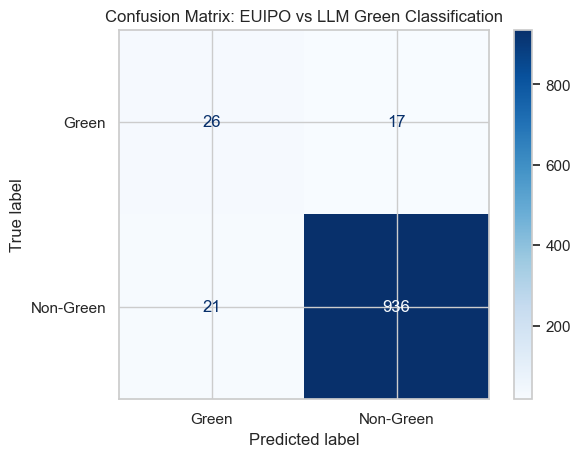

In [535]:
y_true = df_test2["EUIPO_green_dummy"]
y_pred = df_test2["green_LLM2"]

cm = confusion_matrix(y_true, y_pred, labels=[1, 0])  # optional: 1=green, 0=non-green
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Green", "Non-Green"]
)

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: EUIPO vs LLM Green Classification")
plt.show()


# Model predictoins

In [ ]:
model1= SetFitModel.from_pretrained("green_trademark_model_v1")


test_texts = df_test2['full_description'].tolist()


# Predict probabilities

probas = model1.predict_proba(test_texts)[:, 1].detach().cpu().numpy()


#  Choose threshold

best_threshold = 0.7   

# Convert probabilities to labels
preds = (probas >= best_threshold).astype(int)


# Add predictions to your DataFrame

df_test2['green_probam1'] = probas
df_test2['green_predm1'] = preds

print(df_test2[['full_description', 'green_probam1', 'green_predm1']].head())

In [ ]:
y_true = df_test2["green_LLM2"]
y_pred = df_test2["green_predm1"]

cm = confusion_matrix(y_true, y_pred, labels=[1, 0])  
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Green", "Non-Green"]
)

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: EUIPO vs LLM Green Classification")
plt.show()


# model 2

In [ ]:
model2= SetFitModel.from_pretrained("green_trademark_model_v2goed")


test_texts = df_test2['full_description'].tolist()


#  Predict probabilities

probas2 = model2.predict_proba(test_texts)[:, 1].detach().cpu().numpy()


best_threshold = 0.7   

# Convert probabilities to labels
preds2 = (probas2 >= best_threshold).astype(int)


df_test2['green_probam2'] = probas2
df_test2['green_predm2'] = preds2

print(df_test2[['full_description', 'green_probam2', 'green_predm2']].head())

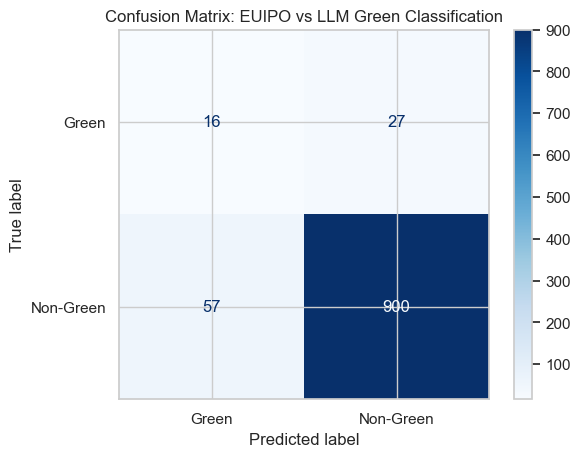

In [ ]:
y_true2 = df_test2["green_LLM2"]
y_pred2 = df_test2["green_predm2"]

cm = confusion_matrix(y_true2, y_pred2, labels=[1, 0]) 
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Green", "Non-Green"]
)

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: EUIPO vs LLM Green Classification")
plt.show()


In [ ]:
model3= SetFitModel.from_pretrained("Model_multilingual-paraphrase")
 

test_texts = df_test2['full_description'].tolist()


#Predict probabilities

probas3 = model3.predict_proba(test_texts)[:, 1].detach().cpu().numpy()


best_threshold = 0.7   

# Convert probabilities to labels
preds3 = (probas3 >= best_threshold).astype(int)


df_test2['green_probam3'] = probas3
df_test2['green_predm3'] = preds3

print(df_test2[['full_description', 'green_probam3', 'green_predm3']].head())

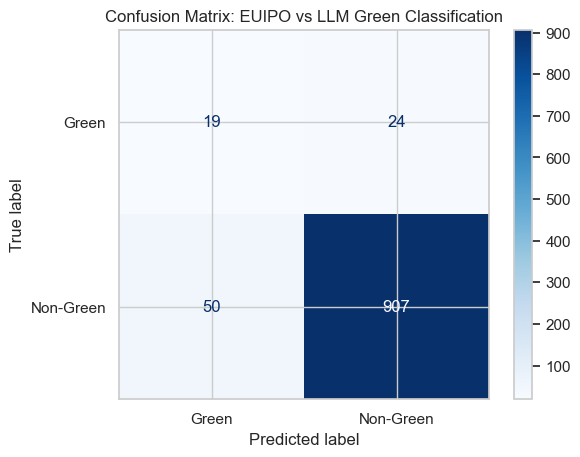

In [ ]:
y_true3 = df_test2["green_LLM2"]
y_pred3 = df_test2["green_predm3"]

cm = confusion_matrix(y_true3, y_pred3, labels=[1, 0])  
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Green", "Non-Green"]
)

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: EUIPO vs LLM Green Classification")
plt.show()


In [ ]:
model4= SetFitModel.from_pretrained("MultiLingOnNewValidation")


test_texts = df_test2['full_description'].tolist()


probas4 = model4.predict_proba(test_texts)[:, 1].detach().cpu().numpy()


best_threshold = 0.7  

# Convert probabilities to labels
preds4 = (probas4 >= best_threshold).astype(int)


df_test2['green_probam4'] = probas4
df_test2['green_predm4'] = preds4

print(df_test2[['full_description', 'green_probam4', 'green_predm4']].head())

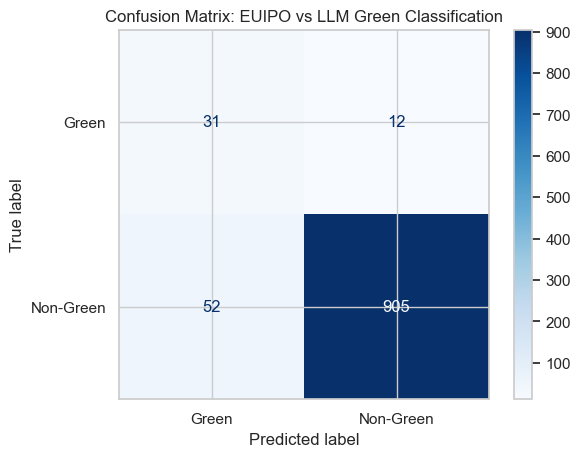

In [ ]:
y_true4 = df_test2["green_LLM2"]
y_pred4 = df_test2["green_predm4"]

cm = confusion_matrix(y_true4, y_pred4, labels=[1, 0]) 
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Green", "Non-Green"]
)

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: EUIPO vs LLM Green Classification")
plt.show()


In [ ]:
model5= SetFitModel.from_pretrained("model1_augmented(best)")
 

test_texts = df_test2['full_description'].tolist()


probas5 = model5.predict_proba(test_texts)[:, 1].detach().cpu().numpy()


best_threshold = 0.7   

# Convert probabilities to labels
preds5 = (probas5 >= best_threshold).astype(int)

df_test2['green_probam5'] = probas5
df_test2['green_predm5'] = preds5

print(df_test2[['full_description', 'green_probam5', 'green_predm5']].head())

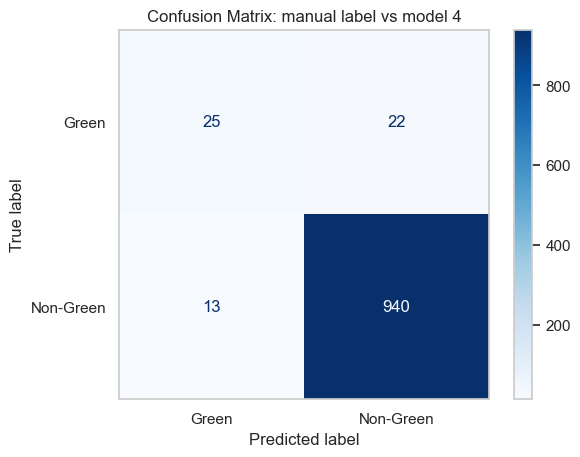

Classification Report:

              precision    recall  f1-score   support

   NOT_GREEN       0.98      0.98      0.98       957
       GREEN       0.58      0.51      0.54        43

    accuracy                           0.96      1000
   macro avg       0.78      0.75      0.76      1000
weighted avg       0.96      0.96      0.96      1000



In [ ]:
y_true5 = final_test['green_LLM2']
y_pred5 = final_test["green_predm5"]

cm = confusion_matrix(y_true5, y_pred5, labels=[1, 0]) 
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Green", "Non-Green"]
)


ax = disp.plot(cmap=plt.cm.Blues).ax_
ax.grid(False)
plt.title("Confusion Matrix: manual label vs model 4")
plt.show()
report = classification_report(final_test['green_LLM'], final_test['green_predm5'], target_names=["NOT_GREEN", "GREEN"])
print("Classification Report:\n")
print(report)

In [463]:
manuallabeledtest= pd.read_excel("merged_spain_predictions2.xlsx")

In [ ]:
df_test2 = df_test2.rename(columns={"application_number": "ApplicationNumber"})

manuallabeledtest_merge = manuallabeledtest[['ApplicationNumber','manual_label']]


final_test = df_test2.merge(
    manuallabeledtest_merge, 
    on='ApplicationNumber', 
    how='left'  
)

In [471]:
final_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ApplicationNumber    1000 non-null   int64  
 1   full_description     1000 non-null   object 
 2   EUIPO_green_dummy    1000 non-null   int64  
 3   ApplicantIdentifier  1000 non-null   float64
 4   owner_name_original  1000 non-null   object 
 5   Country_EUIPO        1000 non-null   object 
 6   LATWGS84             1000 non-null   float64
 7   LONGWGS84            1000 non-null   float64
 8   word_count           1000 non-null   int64  
 9   green_LLM            1000 non-null   int64  
 10  green_probam1        1000 non-null   float64
 11  green_predm1         1000 non-null   int64  
 12  green_probam2        1000 non-null   float64
 13  green_predm2         1000 non-null   int64  
 14  green_probam3        1000 non-null   float64
 15  green_predm3         1000 non-null   in

# Final results of manual labeling and the models

# Model 1 after augmentation

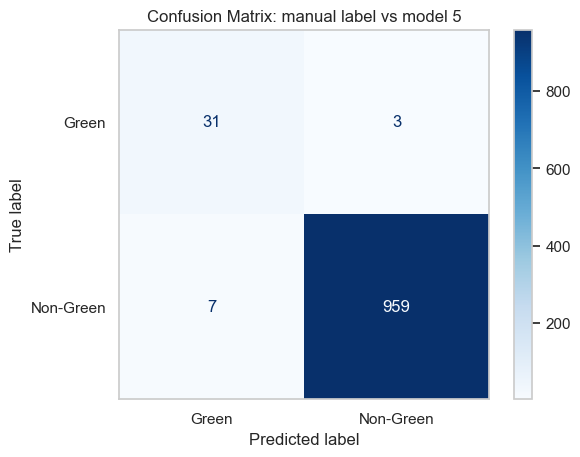

Classification Report:

              precision    recall  f1-score   support

   NOT_GREEN       1.00      0.99      0.99       966
       GREEN       0.82      0.91      0.86        34

    accuracy                           0.99      1000
   macro avg       0.91      0.95      0.93      1000
weighted avg       0.99      0.99      0.99      1000



In [ ]:
y_true5 = final_test["manual_label"]
y_pred5 = final_test["green_predm5"]

cm = confusion_matrix(y_true5, y_pred5, labels=[1, 0])  
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Green", "Non-Green"]
)

ax = disp.plot(cmap=plt.cm.Blues).ax_
ax.grid(False)

plt.title("Confusion Matrix: manual label vs model 5")
plt.show()

report = classification_report(final_test['manual_label'], final_test['green_predm5'], target_names=["NOT_GREEN", "GREEN"])
print("Classification Report:\n")
print(report)



# MultiLingOnNewValidation 

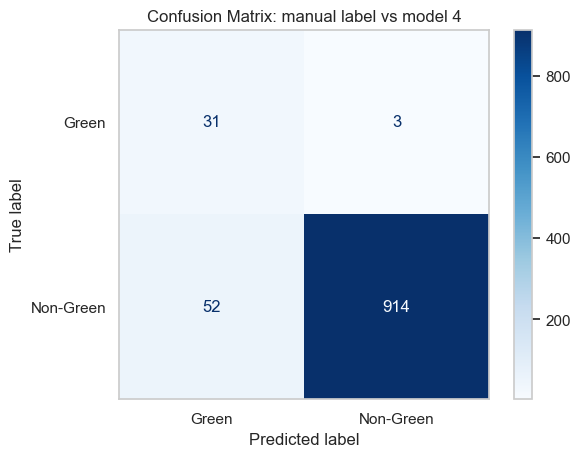

Classification Report:

              precision    recall  f1-score   support

   NOT_GREEN       1.00      0.95      0.97       966
       GREEN       0.37      0.91      0.53        34

    accuracy                           0.94      1000
   macro avg       0.69      0.93      0.75      1000
weighted avg       0.98      0.94      0.96      1000



In [ ]:
y_true5 = final_test["manual_label"]
y_pred5 = final_test["green_predm4"]

cm = confusion_matrix(y_true5, y_pred5, labels=[1, 0])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Green", "Non-Green"]
)

ax = disp.plot(cmap=plt.cm.Blues).ax_
ax.grid(False)
plt.title("Confusion Matrix: manual label vs model 4")
plt.show()
report = classification_report(final_test['manual_label'], final_test['green_predm4'], target_names=["NOT_GREEN", "GREEN"])
print("Classification Report:\n")
print(report)



# multi lingual

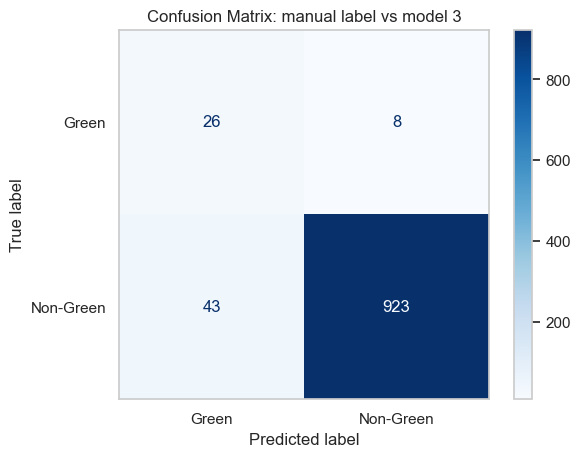

Classification Report:

              precision    recall  f1-score   support

   NOT_GREEN       0.99      0.96      0.97       966
       GREEN       0.38      0.76      0.50        34

    accuracy                           0.95      1000
   macro avg       0.68      0.86      0.74      1000
weighted avg       0.97      0.95      0.96      1000



In [ ]:
y_true5 = final_test["manual_label"]
y_pred5 = final_test["green_predm3"]

cm = confusion_matrix(y_true5, y_pred5, labels=[1, 0]) 
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Green", "Non-Green"]
)

ax = disp.plot(cmap=plt.cm.Blues).ax_
ax.grid(False)
plt.title("Confusion Matrix: manual label vs model 3")
plt.show()
report = classification_report(final_test['manual_label'], final_test['green_predm3'], target_names=["NOT_GREEN", "GREEN"])
print("Classification Report:\n")
print(report)



# Model 2, 'all' sentence transformer

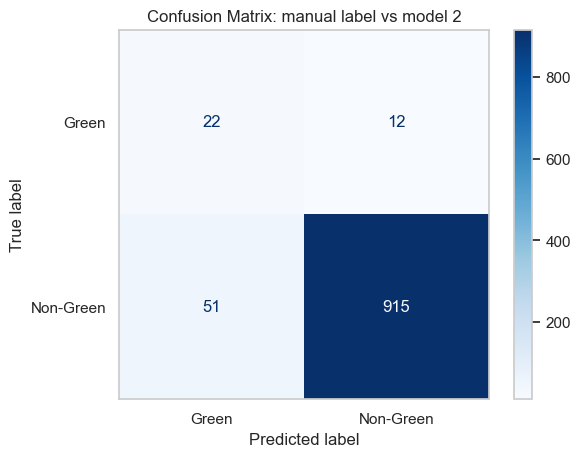

Classification Report:

              precision    recall  f1-score   support

   NOT_GREEN       0.99      0.95      0.97       966
       GREEN       0.30      0.65      0.41        34

    accuracy                           0.94      1000
   macro avg       0.64      0.80      0.69      1000
weighted avg       0.96      0.94      0.95      1000



In [ ]:
y_true5 = final_test["manual_label"]
y_pred5 = final_test["green_predm2"]

cm = confusion_matrix(y_true5, y_pred5, labels=[1, 0])  
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Green", "Non-Green"]
)

ax = disp.plot(cmap=plt.cm.Blues).ax_
ax.grid(False)
plt.title("Confusion Matrix: manual label vs model 2")
plt.show()
report = classification_report(final_test['manual_label'], final_test['green_predm2'], target_names=["NOT_GREEN", "GREEN"])
print("Classification Report:\n")
print(report)



# Model 1 paraphrase without training

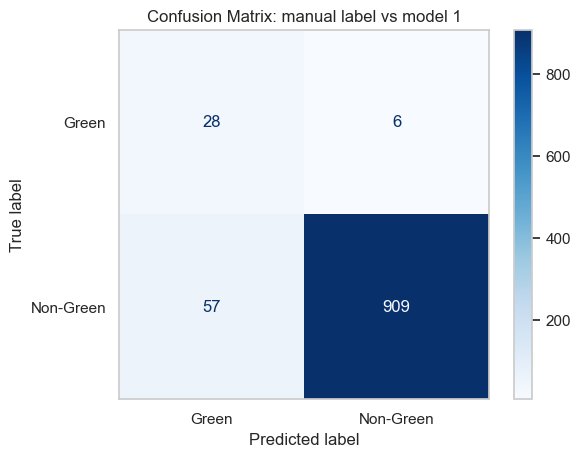

Classification Report:

              precision    recall  f1-score   support

   NOT_GREEN       0.99      0.94      0.97       966
       GREEN       0.33      0.82      0.47        34

    accuracy                           0.94      1000
   macro avg       0.66      0.88      0.72      1000
weighted avg       0.97      0.94      0.95      1000



In [ ]:
y_true5 = final_test["manual_label"]
y_pred5 = final_test["green_predm1"]

cm = confusion_matrix(y_true5, y_pred5, labels=[1, 0])  
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Green", "Non-Green"]
)

ax = disp.plot(cmap=plt.cm.Blues).ax_
ax.grid(False)
plt.title("Confusion Matrix: manual label vs model 1")
plt.show()
report = classification_report(final_test['manual_label'], final_test['green_predm1'], target_names=["NOT_GREEN", "GREEN"])
print("Classification Report:\n")
print(report)



# compare our best model with other ways

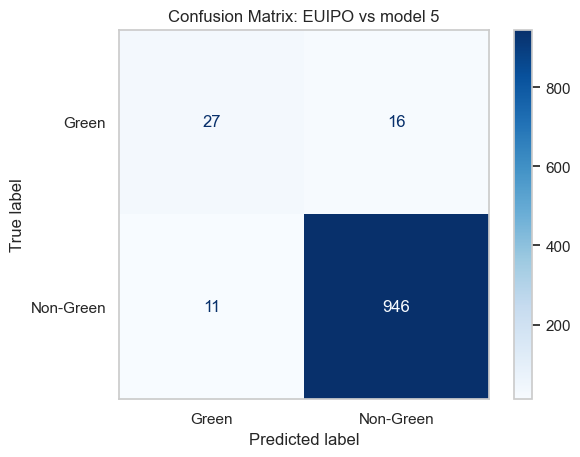

Classification Report:

              precision    recall  f1-score   support

   NOT_GREEN       0.98      0.99      0.99       957
       GREEN       0.71      0.63      0.67        43

    accuracy                           0.97      1000
   macro avg       0.85      0.81      0.83      1000
weighted avg       0.97      0.97      0.97      1000



In [ ]:
y_true5 = final_test["EUIPO_green_dummy"]
y_pred5 = final_test["green_predm5"]

cm = confusion_matrix(y_true5, y_pred5, labels=[1, 0]) 
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Green", "Non-Green"]
)

ax = disp.plot(cmap=plt.cm.Blues).ax_
ax.grid(False)
plt.title("Confusion Matrix: EUIPO vs model 5")
plt.show()
report = classification_report(final_test['EUIPO_green_dummy'], final_test['green_predm5'], target_names=["NOT_GREEN", "GREEN"])
print("Classification Report:\n")
print(report)



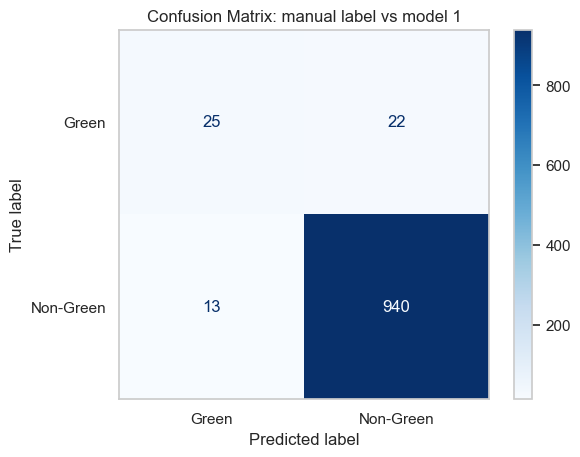

Classification Report:

              precision    recall  f1-score   support

   NOT_GREEN       0.98      0.99      0.98       953
       GREEN       0.66      0.53      0.59        47

    accuracy                           0.96      1000
   macro avg       0.82      0.76      0.78      1000
weighted avg       0.96      0.96      0.96      1000



In [ ]:
y_true5 = final_test["green_LLM2"]
y_pred5 = final_test["green_predm5"]

cm = confusion_matrix(y_true5, y_pred5, labels=[1, 0])  
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Green", "Non-Green"]
)

ax = disp.plot(cmap=plt.cm.Blues).ax_
ax.grid(False)
plt.title("Confusion Matrix:)
plt.show()
report = classification_report(final_test['green_LLM2'], final_test['green_predm5'], target_names=["NOT_GREEN", "GREEN"])
print("Classification Report:\n")
print(report)



In [517]:
final_test.to_excel("Final_df.xlsx", index=False)

#  Confusion Matrix of EUIPO approach on Manual Labeling


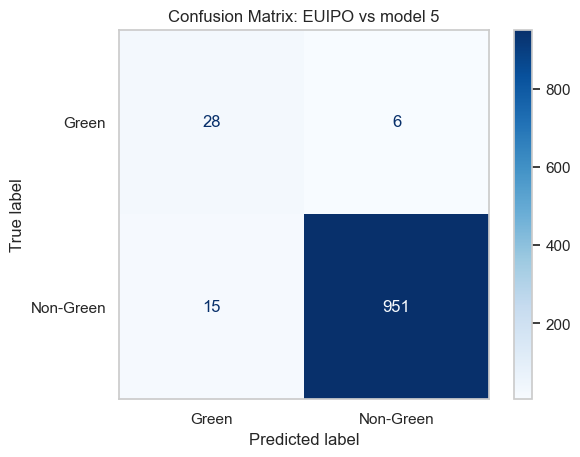

Classification Report:

              precision    recall  f1-score   support

   NOT_GREEN       0.99      0.98      0.99       966
       GREEN       0.65      0.82      0.73        34

    accuracy                           0.98      1000
   macro avg       0.82      0.90      0.86      1000
weighted avg       0.98      0.98      0.98      1000



In [ ]:
y_true5 = final_test["manual_label"]
y_pred5 = final_test["EUIPO_green_dummy"]

cm = confusion_matrix(y_true5, y_pred5, labels=[1, 0]) 
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Green", "Non-Green"]
)

ax = disp.plot(cmap=plt.cm.Blues).ax_
ax.grid(False)
plt.title("Confusion Matrix: ")
plt.show()
report = classification_report(final_test['manual_label'], final_test['EUIPO_green_dummy'], target_names=["NOT_GREEN", "GREEN"])
print("Classification Report:\n")
print(report)



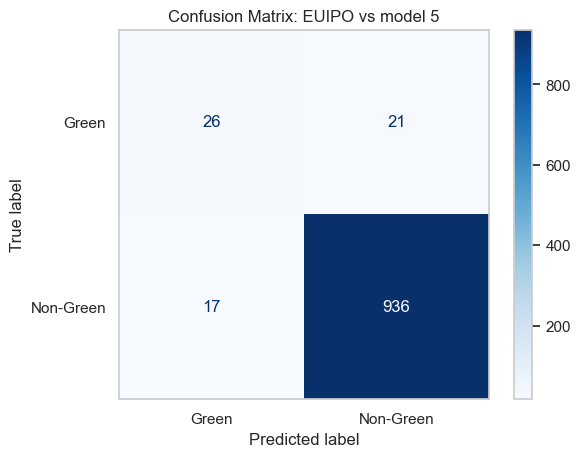

Classification Report:

              precision    recall  f1-score   support

   NOT_GREEN       0.98      0.98      0.98       953
       GREEN       0.60      0.55      0.58        47

    accuracy                           0.96      1000
   macro avg       0.79      0.77      0.78      1000
weighted avg       0.96      0.96      0.96      1000



In [ ]:
y_true5 = final_test["green_LLM2"]
y_pred5 = final_test["EUIPO_green_dummy"]

cm = confusion_matrix(y_true5, y_pred5, labels=[1, 0])  
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Green", "Non-Green"]
)

ax = disp.plot(cmap=plt.cm.Blues).ax_
ax.grid(False)
plt.title("Confusion Matrix: ")
plt.show()
report = classification_report(final_test['green_LLM2'], final_test['EUIPO_green_dummy'], target_names=["NOT_GREEN", "GREEN"])
print("Classification Report:\n")
print(report)



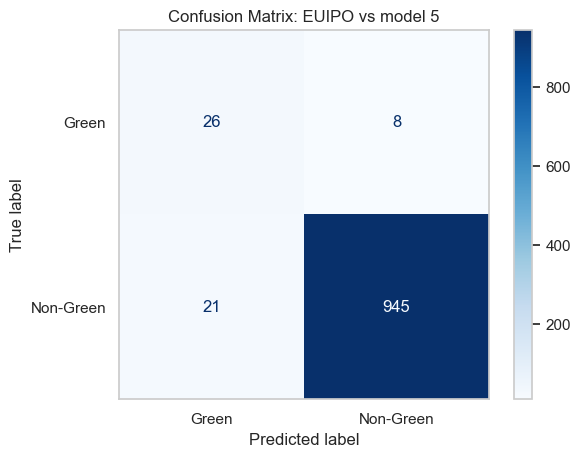

Classification Report:

              precision    recall  f1-score   support

   NOT_GREEN       0.99      0.98      0.98       966
       GREEN       0.55      0.76      0.64        34

    accuracy                           0.97      1000
   macro avg       0.77      0.87      0.81      1000
weighted avg       0.98      0.97      0.97      1000



In [ ]:
y_true5 = final_test["manual_label"]
y_pred5 = final_test["green_LLM2"]

cm = confusion_matrix(y_true5, y_pred5, labels=[1, 0])  
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Green", "Non-Green"]
)

ax = disp.plot(cmap=plt.cm.Blues).ax_
ax.grid(False)
plt.title("Confusion Matrix: ")
plt.show()
report = classification_report(final_test['manual_label'], final_test['green_LLM2'], target_names=["NOT_GREEN", "GREEN"])
print("Classification Report:\n")
print(report)



# different models on manual labeling

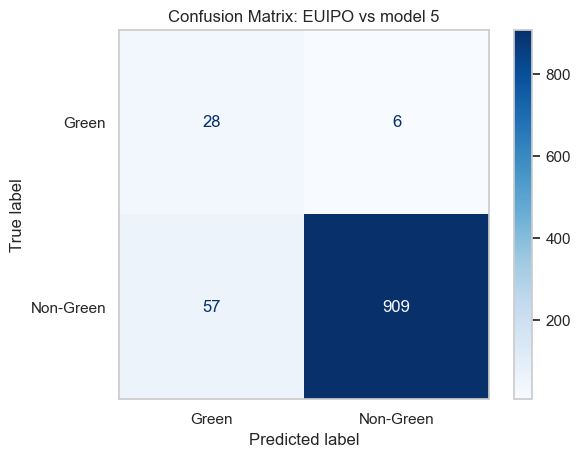

Classification Report:

              precision    recall  f1-score   support

   NOT_GREEN       0.99      0.94      0.97       966
       GREEN       0.33      0.82      0.47        34

    accuracy                           0.94      1000
   macro avg       0.66      0.88      0.72      1000
weighted avg       0.97      0.94      0.95      1000



In [ ]:
y_true5 = final_test["manual_label"]
y_pred5 = final_test["green_predm1"]

cm = confusion_matrix(y_true5, y_pred5, labels=[1, 0])  
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Green", "Non-Green"]
)

ax = disp.plot(cmap=plt.cm.Blues).ax_
ax.grid(False)
plt.title("Confusion Matrix: ")
plt.show()
report = classification_report(final_test['manual_label'], final_test['green_predm1'], target_names=["NOT_GREEN", "GREEN"])
print("Classification Report:\n")
print(report)



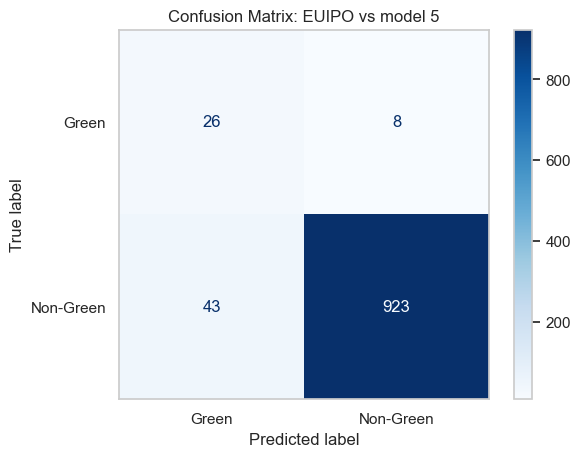

Classification Report:

              precision    recall  f1-score   support

   NOT_GREEN       0.99      0.96      0.97       966
       GREEN       0.38      0.76      0.50        34

    accuracy                           0.95      1000
   macro avg       0.68      0.86      0.74      1000
weighted avg       0.97      0.95      0.96      1000



In [ ]:
y_true5 = final_test["manual_label"]
y_pred5 = final_test["green_predm3"]

cm = confusion_matrix(y_true5, y_pred5, labels=[1, 0])  
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Green", "Non-Green"]
)

ax = disp.plot(cmap=plt.cm.Blues).ax_
ax.grid(False)
plt.title("Confusion Matrix: ")
plt.show()
report = classification_report(final_test['manual_label'], final_test['green_predm3'], target_names=["NOT_GREEN", "GREEN"])
print("Classification Report:\n")
print(report)



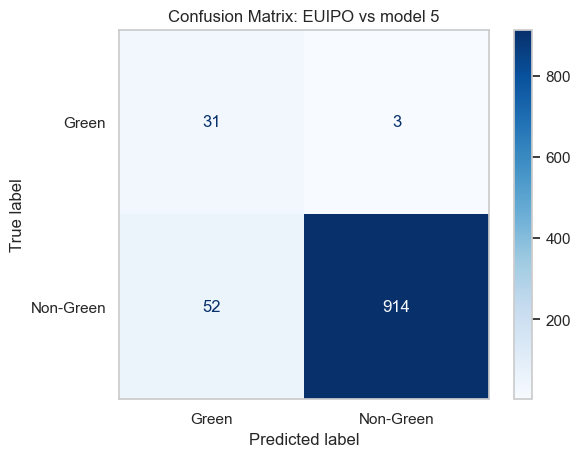

Classification Report:

              precision    recall  f1-score   support

   NOT_GREEN       1.00      0.95      0.97       966
       GREEN       0.37      0.91      0.53        34

    accuracy                           0.94      1000
   macro avg       0.69      0.93      0.75      1000
weighted avg       0.98      0.94      0.96      1000



In [ ]:
y_true5 = final_test["manual_label"]
y_pred5 = final_test["green_predm4"]

cm = confusion_matrix(y_true5, y_pred5, labels=[1, 0])  
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Green", "Non-Green"]
)

ax = disp.plot(cmap=plt.cm.Blues).ax_
ax.grid(False)
plt.title("Confusion Matrix: ")
plt.show()
report = classification_report(final_test['manual_label'], final_test['green_predm4'], target_names=["NOT_GREEN", "GREEN"])
print("Classification Report:\n")
print(report)

